## 本程序调用构建好的网络，对读取的test数据集进行预测，并对结果进行分析

## test数据集目前在“datasets”文件夹下，模型在“nn_train”文件夹内，输出包括预测的结果和结果分析，为csv和txt文件，默认放置在“pre_analysis”中

## 本程序主要针对于连续label，如CR

last update: 2022.5.20

在36_预测分析_CN_20220519上进行修改，将部分计算和绘图提升为函数。优化了文件输出名。

contacts：zhaohf@ihep.ac.cn

# 配置环境

通用模块构建
  检查python、Tensorflow等模块的版本，确保搭建的框架能够稳定运行。

In [1]:
import os
import sys
assert sys.version_info >= (3, 5)
#
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
#
# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

from tensorflow import keras
#from tensorflow.keras import optimizers
#
# pydot_ng and graphviz are for tf.keras.utils.plot_model
# note that installing pydot_ng is 'pydot-ng'
# note that 在windows下不可以使用pip install graphviz 下载graphviz安装包，
# 要去https://graphviz.gitlab.io/下载windows版本的安装包，安装好之后在环境变量中添加对应的路径即可！！！
import graphviz
import pydot
import pydot_ng
#
import time
import math

输出导入模板的版本。

In [2]:
print('python version:',sys.version)
print('TensorFlow version:',tf.__version__)
print('numpy version:',np.__version__)
print('panda version:',pd.__version__)
print('matplotlib version:',mpl.__version__)
print('graphviz version:',graphviz.__version__)
print('pydot version:',pydot.__version__)
print('pydot_ng version:',pydot_ng.__version__)
#
#print('time version:',time.__version__)
#print('math version:',math.__version__)

python version: 3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]
TensorFlow version: 2.7.0
numpy version: 1.21.5
panda version: 1.4.2
matplotlib version: 3.5.1
graphviz version: 0.20
pydot version: 1.4.2
pydot_ng version: 2.0.0


# 参数设置

## 配置输入文件夹

设置ML模型的文件夹路径和文件名

In [3]:
dir_model = './../nn_train'
file_saved_model = 'au150_DW_ann_chi_cr1_200_20_1_run_2022_05_28-15_27_10.h5'

设置需要预测的文件的路径和文件名

In [4]:
dir_data = './../datasets'
file_feature_test = 'Au_chi_test.txt'
file_label_test = 'Au_cr1_test.txt'

## 配置输出文件夹

设置预测结果和预测分析所放置的文件夹

In [5]:
dir_ana = './../pre_analysis'

设置feature,label标签，用于后面模型训练、绘图

In [6]:
feature_index = 'chi'
label_index = 'CR1'

## 以后还得增加连续值的间隔设置

# 部分函数模块

## 设置绘图格式和保存图片的模块

  确保绘制的图形美观、能保存下来。

In [7]:
# To plot pretty figures
# %matplotlib具体作用是调用matplotlib.pyplot的绘图函数plot()进行绘图时，
# 或生成一个figure画布时，可以直接在你的python console里面生成图像。
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)   # matplotlib.rc 什么意思没找到
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

def save_fig(IMAGES_PATH, fig_id, tight_layout=True, fig_extension="png", resolution=300):
    os.makedirs(IMAGES_PATH, exist_ok=True)
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
#    plt.show()

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## 分析label统计函数

In [8]:
def lab_ana(label_test):
    """
    """
    label_mean = np.mean(label_test)
    label_diff = label_test - label_mean
    label_diff_abs = np.abs(label_diff)
    label_err = label_diff / label_test
    label_err_abs = np.abs(label_err)
    attr_dict2 = {
        'Mean'                   : label_mean,
        'Max'                    : np.max(label_test),
        'Min'                    : np.min(label_test),
        'diff_Max'               : np.max(label_diff),
        'diff_Min'               : np.min(label_diff),
        '|diff|_Mean'            : np.mean(label_diff_abs),
        '|diff|_Max'             : np.max(label_diff_abs),
        '|diff|_Min'             : np.min(label_diff_abs),
        'Var'                    : np.var(label_test),
        'Std'                    : np.std(label_test),
        'Error_mean'             : np.mean(label_err),
        'Error_max'              : np.max(label_err),
        'Error_min'              : np.min(label_err),
        '|Error|_mean'           : np.mean(label_err_abs),
        '|Error|_max'            : np.max(label_err_abs),
        '|Error|_min'            : np.min(label_err_abs),
        'Midd'                   : np.median(label_test)
    }
    return attr_dict2

## 预测分析统计函数

In [9]:
def pre_ana(pre, label_test):
    """
    """
    diff = pre - label_test
    diff_abs = np.abs(diff)
    diff2 = np.square(diff)  # = diff**2
    #pre_var_mean = np.mean(diff2, axis=0)
    pre_var_mean = np.mean(diff2)
    pre_var_std = np.sqrt(pre_var_mean)  # = pre_var_mean**0.5
    err = diff / label_test
    err_abs = np.abs(err)
    attr_dict3 = {
        'diff_Max': np.max(diff),
        'diff_Min': np.min(diff),
        '|diff|_Mean(MAE)': np.mean(diff_abs),
        '|diff|_Max': np.max(diff_abs),
        '|diff|_Min': np.min(diff_abs),
        'pre_Var(MSE)': pre_var_mean,
        'pre_Std(RMSE)': pre_var_std,
        'Error_mean': np.mean(err),
        'Error_max': np.max(err),
        'Error_min': np.min(err),
        '|Error|_mean(MAPE)': np.mean(err_abs),
        '|Error|_max': np.max(err_abs),
        '|Error|_min': np.min(err_abs)
    }
    return attr_dict3, diff, diff_abs, err, err_abs

## 分析结果保存csv文件函数

In [10]:
import pandas as pd
def pre_ana2csv(label_test, pre, diff, diff_abs, err, err_abs, path_pre_csv):
    """
    """
    df = pd.DataFrame([label_test.flatten(),
                       pre.flatten(),   # pre.T[0] also works
                       diff.flatten(),
                       diff_abs.flatten(),
                       err.flatten(),
                       err_abs.flatten()]) 
    df = df.transpose() 
    head = [f'{label_index}_real',
            f'{label_index}_pre',
            f'{label_index}_diff',
            f'|{label_index}_diff|',
            f'{label_index}_err',
            f'|{label_index}_err|']
    df.to_csv(path_pre_csv, index=False, header=head)

## 分析结果保存为txt文件 

In [11]:
def pre_ana2txt(label_test, pre, diff, diff_abs, err, err_abs, path_pre_txt):
    """
    """
    fout = open(path_pre_txt,'w')
#
    str_no = 'No.'
    str_lab = 'Label'
    str_pre = 'Predict'
    str_diff = 'Diff'
    str_diff_abs = '|Diff|'
    str_err = 'Error'
    str_err_abs = '|Error|'
    #str_avg = 'Avg.'
    #str_max = 'Max.'
    #str_min = 'Min.'
    #str_var = 'Var.(MSE)'
    #str_std = 'Std.(RMES)'
    # n_xx 是输出格式中各列的占位数
    n_maxnd_label = 5                          # label的个数，如1万，则需要5位数
    #n_no = max(n_maxnd_label,len(str_no),len(str_avg),len(str_max),len(str_min),len(str_var),len(str_std))
    n_no = max(n_maxnd_label,len(str_no))
    n_lab_after_dot = 3                        # label本身（如12.0）小数点后面位数
    n_lab_before_dot = 1                        # label本身（如12.0）小数点前面位数
    n_lab = max(n_lab_before_dot+1+n_lab_after_dot,len(str_lab))     #label不会是负数
    n_pre_after_dot = 4
    n_pre_before_dot = n_lab_before_dot
    n_pre = max(n_pre_before_dot+1+n_pre_after_dot,len(str_pre))
    n_diff = max(n_pre_before_dot+1+n_pre_after_dot+1,len(str_diff))   # 考虑负号
    n_diff_abs = max(n_pre_before_dot+1+n_pre_after_dot,len(str_diff_abs))
    n_err_after_dot = 3
    n_err = max(n_err_after_dot+4+2+1,len(str_err))
    n_err_abs = max(n_err_after_dot+4+2,len(str_err_abs))
    #
    print(f"{'*'*5:>5} Model   : {dir_model}/{file_saved_model}")
    print(f"{'*'*5:>5} Fearute : {dir_data}/{file_feature_test}")
    print(f"{'*'*5:>5} Label   : {dir_data}/{file_label_test}")
    print(f"{'*'*5:>5} Model   : {dir_model}/{file_saved_model}", file=fout)
    print(f"{'*'*5:>5} Fearute : {dir_data}/{file_feature_test}", file=fout)
    print(f"{'*'*5:>5} Label   : {dir_data}/{file_label_test}", file=fout)
    print(f"Total   : {pre.size} data")
    print(f"Total   : {pre.size} data", file=fout)
    print(f"\n{str_no:>{n_no}} {str_lab:>{n_lab}} {str_pre:>{n_pre}} {str_diff:>{n_diff}} {str_diff_abs:>{n_diff_abs}} {str_err:>{n_err}} {str_err_abs:>{n_err_abs}}")
    print(f"\n{str_no:>{n_no}} {str_lab:>{n_lab}} {str_pre:>{n_pre}} {str_diff:>{n_diff}} {str_diff_abs:>{n_diff_abs}} {str_err:>{n_err}} {str_err_abs:>{n_err_abs}}", file=fout)
    print(f"{'-'*(n_no+1+n_lab+1+n_pre+1+n_diff+1+n_diff_abs+1+n_err+1+n_err_abs)}")
    print(f"{'-'*(n_no+1+n_lab+1+n_pre+1+n_diff+1+n_diff_abs+1+n_err+1+n_err_abs)}", file=fout)
    for i in range(pre.size):
        print(f"{i+1:>{n_no}d} {label_test[i][0]:>{n_lab}.{n_lab_after_dot}f} {pre[i][0]:>{n_pre}.{n_pre_after_dot}f} {diff[i][0]:>{n_diff}.{n_pre_after_dot}f} {diff_abs[i][0]:>{n_diff_abs}.{n_pre_after_dot}f} {err[i][0]:>{n_err}.{n_err_after_dot}E} {err_abs[i][0]:>{n_err_abs}.{n_err_after_dot}E}")
        print(f"{i+1:>{n_no}d} {label_test[i][0]:>{n_lab}.{n_lab_after_dot}f} {pre[i][0]:>{n_pre}.{n_pre_after_dot}f} {diff[i][0]:>{n_diff}.{n_pre_after_dot}f} {diff_abs[i][0]:>{n_diff_abs}.{n_pre_after_dot}f} {err[i][0]:>{n_err}.{n_err_after_dot}E} {err_abs[i][0]:>{n_err_abs}.{n_err_after_dot}E}", file=fout)
#
    fout.close()

## 保存dictionary文件

In [12]:
def dict2txt(filepath, note, dic, wa='w'):
    """
    """
    fout = open(filepath,wa)
    print(note)
    print(note,file=fout)
    for key in dic.keys():
        print(f"  {key:<20}: {dic[key]:>10.7f}")
        print(f"  {key:<20}: {dic[key]:>10.7f}",file=fout)
    fout.close()

## 将一个整数序列（含有多个连续零）改造成只包含少量零的序列，供作图使用

In [13]:
def list_modify(start, end, list0):
    """
    删除list0(start, end)中0元素连续超过三个的部分，只保留有非零周围的0，返回修正过的列表和列表各元素所在的序号
    这里假设list0[start]和list0[end]都不为0。
    """
    list_index = []
    list_modify = []
    if start == end:
        list_index = [start]
        list_modify = [list0[start]]
        return list_index, list_modify
    if start > end:
        print(f"\n{'#'*10:10}Warning!! Error list!")
        print(f"{' ':10}Start({start}) > End({end}) !")
#        sys.exit(0)
        return [], []
#
    for i in range(start,end):    #注意，这里估计不统计list0[end]因为它不为零
        j = list0[i] + list0[i+1]
        if j != 0:
            list_index.append(i)
            list_modify.append(list0[i])
        else:
            k = list0[i] + list0[i-1]
            if k != 0:
                list_index.append(i)
                list_modify.append(list0[i])
    list_index.append(end)
    list_modify.append(list0[end])
    return list_index, list_modify

In [14]:
def list_modify_without0(start, end, list0):
    """
    删除list0(start, end)中所有0元素，返回修正过的列表和列表各元素所在的序号
    这里假设list0[start]和list0[end]都不为0。
    """
    list_index = []
    list_modify = []
    if start == end:
        list_index = [start]
        list_modify = [list0[start]]
        return list_index, list_modify
    if start > end:
        print(f"\n{'#'*10:10}Warning!! Error list!")
        print(f"{' ':10}Start({start}) > End({end}) !")
#        sys.exit(0)
        return [], []
#
    for i in range(start,end):    #注意，这里估计不统计list0[end]因为它不为零
        j = list0[i]
        if j != 0:
            list_index.append(i)
            list_modify.append(j)
    list_index.append(end)
    list_modify.append(list0[end])
    return list_index, list_modify

## 绘制每个单独CR的预测分布

函数解释：
matplotlib.pyplot.text(x, y, s, fontdict=None, withdash=False, **kwargs)

常用参数说明：

x，y：显示内容的坐标位置

s：显示内容

fontdict：一个定义s格式的dict

fontsize：字体大小

color：str or tuple, 设置字体颜色 ,单个字符候选项{‘b’, ‘g’, ‘r’, ‘c’, ‘m’, ‘y’, ‘k’, ‘w’}，也可以’black’,'red’等，tuple时用[0,1]之间的浮点型数据，RGB或者RGBA, 如: (0.1, 0.2, 0.5)、(0.1, 0.2, 0.5, 0.3)等

backgroundcolor：字体背景颜色

horizontalalignment(ha)：设置垂直对齐方式，可选参数：left,right,center

verticalalignment(va)：设置水平对齐方式 ，可选参数 ： ‘center’ , ‘top’ , ‘bottom’ ,‘baseline’

rotation(旋转角度)：可选参数为:vertical,horizontal 也可以为数字

alpha：透明度，参数值0至1之间
————————————————
版权声明：本文为CSDN博主「Test_Box」的原创文章，遵循CC 4.0 BY-SA版权协议，转载请附上原文出处链接及本声明。
原文链接：https://blog.csdn.net/joson1234567890/article/details/103835674

In [15]:
# 绘制各个cluster的CR统计图
def plot_pre_label(x0min, x0max, y, xmin, xmax, xminmin, step, digit, path, file):
    """
    绘制每个单独label的预测分布
    x0min, x0max：真实值区间的最小、最大值；
    y: 列表，其第i个元素为所有样本预测值位于区间[(i+xminmin)*step, (i+1+xminmin)*step)中的个数
    xmin,xmax: 为y列表中非零数的最小和最大区间号。
    xminmin: 如上。
    step: 间隔
    digit：自然数，用于给出绘制图中x轴数字的有效位数，如果步长为0.1，则为1，若步长为0.05， 则为2
    path：图的保存路径
    file：图的名称（不包含后缀）    
    """
#
# 为了绘图中的x轴上显示更为清晰，设置step_plot，让其的整数倍显示数字
    step_plot = 1
# 设置一个很小的数
    trivial = min(0.00001, step/100)
#
    #fig = plt.figure(num=1, figsize=(15, 8),dpi=80) #开启一个窗口，同时设置大小，分辨率
    fig = plt.figure()
    ax1 = fig.add_subplot(1,1,1)
#
    m = math.floor((x0min+trivial)/step) - xminmin
    n = math.ceil((x0max-trivial)/step) - xminmin
    x_min = min(xmin,m)
    x_max = max(xmax,n-1)
    len_x = x_max - x_min + 1
#
    rotation = 0
    fontsize = 10
    if len_x >= 12:
        rotation = 30
        if len_x >= 20 :
            fontsize = 8
            if len_x >= 25:
                fontsize = 6
#
    x_index = np.around(np.arange(x_min+xminmin,x_max+1+xminmin)*step,digit)
    y_index = np.array(list(np.zeros(xmin-x_min,dtype=int))+y[xmin:xmax+1]+list(np.zeros(x_max-xmax,dtype=int)))
#    print()
#    print(f"[x0min,xmax] = [{x0min},{x0max}]")
#    print(f"step = {step}")
#    print(f"xminmin = {xminmin}")
#    print(f"m = {m}, n = {n}")
#    print(f"xmin = {xmin}, xmax = {xmax}")
#    print(f"y[{x_min} : {x_max+1}] = {y[x_min:x_max+1]}")
#    print(f"y_index = {y_index}")
#
    bar_width = step #定义一个数字代表每个独立柱的宽度
#
    rects1 = ax1.bar(x_index, y_index, width=bar_width,align='edge',alpha=0.5, color='yellow',edgecolor='red',label=file)
# 将y_index的值标注在柱状图上，但又不显示为0的数字，因此准备新建一个列表，让其内容与y_index一样，不过0的地方改为无字符''
#
    y_text = []
    for i in list(y_index):
        if i == 0 :
            y_text.append('')
        else:
            y_text.append(i)
#
    for a,b,c in zip(x_index,y_index,y_text):
#        plt.text(a+step/2, b+0.05, '%.0f' % b, ha='center', va= 'bottom',fontsize=fontsize)
        plt.text(a+step/2, b+0.05, c, ha='center', va= 'bottom',fontsize=fontsize)
#
#    plt.xticks(x_index + bar_width/2, x_data) #x轴刻度线
    ax1.set_xticks(np.append(x_index,round((x_max+1+xminmin)*step,digit)))
# 设置x轴上的label。原则是0.5的倍数的，都显示；非零的bar的两边，都显示数字。
    x_ticklabels = []
    for i, a in enumerate(list(x_index)):
        if abs((a/step_plot)-int((a+trivial)/step_plot)) < trivial:
            x_ticklabels.append(a)
        elif y_index[i] != 0:
            x_ticklabels.append(a)
        elif y_index[i]+y_index[i-1] != 0:
            x_ticklabels.append(a)
        elif round((a+trivial)/step) - round((x0min+trivial)/step) < trivial:
            x_ticklabels.append(a)
        elif round((a+trivial)/step) - round((x0max+trivial)/step) < trivial:
            x_ticklabels.append(a)
        else:
            x_ticklabels.append('')
    x_ticklabels.append(round((x_max+1+xminmin)*step,digit))
    ax1.set_xticklabels(np.array(x_ticklabels),rotation=rotation,fontsize=fontsize)
#
#    ax1.set_xlim(min(x0,xmin*step), max(x0,xmax*step))
    ax1.set_ylim(0, max(y)*1.15)
    ax1.set_xlabel('Predicted label')
    ax1.set_ylabel('Number')
    ax1.set_title(f"Prediction Performance",fontsize=12)
#
    plt.vlines(x0min, 0, max(y), colors="blue", linestyles="dashed", linewidth=2, label = label_index+f"=[{x0min},{x0max})")
    plt.vlines(x0max, 0, max(y), colors="blue", linestyles="dashed", linewidth=2)
#
#    plt.legend('upper right') #显示图例
    plt.legend(fontsize=fontsize) #显示图例
    plt.tight_layout() #自动控制图像外部边缘，此方法不能够很好的控制图像间的间隔
#
    save_fig(path, file)
    plt.close(fig)

In [16]:
# 绘制各个cluster的CR统计图
def plot_pre_label_err(label_min, label_max, x0min, x0max, y, xmin, xmax, xminmin, step, digit, path, file):
    """
    绘制每个单独label的预测error分布

    label_min, label_max 是label的区间
    x0min, x0max：error最小最大值；
    y: 列表，其第i个元素为所有样本预测值位于区间[(i+xminmin)*step, (i+1+xminmin)*step)中的个数.
    xmin,xmax: 为y列表中非零数的最小和最大区间号。
    xminmin: 如上。
    step: 间隔
    digit：自然数，用于给出绘制图中x轴数字的有效位数，如果步长为0.1，则为1，若步长为0.05， 则为2
    path：图的保存路径
    file：图的名称（不包含后缀）    
    """
#
# 为了绘图中的x轴上显示更为清晰，设置step_plot，让其的整数倍显示数字
    step_plot = 1
# 设置一个很小的数
    trivial = min(0.00001,step/100)
#
    #fig = plt.figure(num=1, figsize=(15, 8),dpi=80) #开启一个窗口，同时设置大小，分辨率
    fig = plt.figure()
    ax1 = fig.add_subplot(1,1,1)
#
    len_x = xmax - xmin + 1
#
    rotation = 0
    fontsize = 10
    if len_x >= 12:
        rotation = 30
        if len_x >= 20 :
            fontsize = 8
            if len_x >= 25:
                fontsize = 6
#
    x_index = np.around(np.arange(xmin+xminmin,xmax+1+xminmin)*step,digit)
    y_index = np.array(y[xmin:xmax+1])
#    print(label)
#    print(np.arange(xmin,xmax+1))
#    print(x_index)
#    print(f"y[{xmin} : {xmax+1}] = {y[xmin:xmax+1]}")
#    print(f"y_index = {y_index}")
#
    bar_width = step #定义一个数字代表每个独立柱的宽度
#
    rects1 = ax1.bar(x_index, y_index, width=bar_width,align='edge',alpha=0.5, color='yellow',edgecolor='red',label=file)
# 将y_index的值标注在柱状图上，但又不显示为0的数字，因此准备新建一个列表，让其内容与y_index一样，不过0的地方改为无字符''
#
    y_text = []
    for i in list(y_index):
        if i == 0 :
            y_text.append('')
        else:
            y_text.append(i)
#
    for a,b,c in zip(x_index,y_index,y_text):
#        plt.text(a+step/2, b+0.05, '%.0f' % b, ha='center', va= 'bottom',fontsize=fontsize)
        plt.text(a+step/2, b+0.05, c, ha='center', va= 'bottom',fontsize=fontsize)
#
#    plt.xticks(x_index + bar_width/2, x_data) #x轴刻度线
    ax1.set_xticks(np.append(x_index,round((xmax+1+xminmin)*step,digit)))
# 设置x轴上的label。原则是0.5的倍数的，都显示；非零的bar的两边，都显示数字。
    x_ticklabels = []
    for i, a in enumerate(list(x_index)):
        if abs((a/step_plot)-int((a+trivial)/step_plot)) < trivial:
            x_ticklabels.append(a)
        elif y_index[i] != 0:
            x_ticklabels.append(a)
        elif y_index[i]+y_index[i-1] != 0:
            x_ticklabels.append(a)
        else:
            x_ticklabels.append('')
    x_ticklabels.append(round((xmax+1+xminmin)*step,digit))
    ax1.set_xticklabels(np.array(x_ticklabels),rotation=rotation,fontsize=fontsize)
#
#    ax1.set_xlim(min(x0,xmin*step), max(x0,xmax*step))
    ax1.set_ylim(0, max(y)*1.15)
    ax1.set_xlabel(f"Predict {label_index} error")
    ax1.set_ylabel('Number')
    ax1.set_title(f"Prediction Performance for {label_index} = [{label_min:>{digit+2}.{digit}f},{label_max:>{digit+2}.{digit}f})",fontsize=12)
#
    plt.vlines(x0min, 0, max(y), colors="green", linestyles="dashed", linewidth=1.5, label = 'error_min')
    plt.vlines(x0max, 0, max(y), colors="blue", linestyles="dashed", linewidth=1.5, label = 'error_max')
    plt.vlines(0, 0, max(y), colors="black", linestyles="dashed", linewidth=3, label = 'error=0')
#
#    plt.legend('upper right') #显示图例
    plt.legend(fontsize=fontsize) #显示图例
    plt.tight_layout() #自动控制图像外部边缘，此方法不能够很好的控制图像间的间隔
#
    save_fig(path, file)
    plt.close(fig)

# 正文

## 确定当前目录和工作目录

In [17]:
path = os.path.abspath(os.curdir)
path

'D:\\haifeng\\work_20211031\\XAS-ML\\code\\neural network module\\jupyternotebook_code'

检查这些文件是否存在

In [18]:
path_dir_data = os.path.join(path,dir_data)
for file in (file_feature_test, file_label_test):
    path_file = os.path.join(path_dir_data,file)
#
# 检查csv是否存在，若不存在，报错
    exist = os.path.exists(path_file)
    if not exist:
        print()
        print(f"** Error!! cannot find file {file_data[i]} in directory {dir_data}! **")
        print()
        sys.exit()

## 数据导入

### 读取test文件，制成数据集。

In [19]:
import pandas as pd
path_file = os.path.join(path_dir_data,file_feature_test)
#   df.values, df.as_matrix() and np.array(df) all works.
data_df = pd.read_csv(path_file,header=None,delim_whitespace=True)
feature_test = data_df.values
#
path_file = os.path.join(path_dir_data,file_label_test)
#   df.values, df.as_matrix() and np.array(df) all works.
data_df = pd.read_csv(path_file,header=None,delim_whitespace=True)
label_test = data_df.values

In [20]:
print(feature_test.shape, label_test.shape)

(595, 400) (595, 1)


In [21]:
feature_test

array([[ 1.562486e-01,  1.549052e-01,  1.508934e-01, ..., -1.077191e-07,
        -3.554264e-07, -5.424697e-07],
       [ 2.557644e-01,  2.537106e-01,  2.477222e-01, ..., -1.224513e-06,
        -1.189495e-06, -1.089308e-06],
       [ 8.617267e-02,  8.524817e-02,  8.253932e-02, ..., -4.987466e-07,
        -7.527434e-07, -9.162964e-07],
       ...,
       [ 1.633016e-01,  1.616820e-01,  1.571817e-01, ..., -1.616210e-06,
        -1.438373e-06, -1.191754e-06],
       [ 2.649083e-01,  2.628461e-01,  2.568242e-01, ...,  5.872027e-07,
         7.930178e-07,  9.127764e-07],
       [ 2.487297e-01,  2.467340e-01,  2.409130e-01, ..., -2.460035e-06,
        -2.220299e-06, -1.854691e-06]])

In [22]:
label_test

array([[2.798],
       [2.852],
       [2.861],
       [2.81 ],
       [2.847],
       [2.768],
       [2.934],
       [2.926],
       [2.961],
       [2.994],
       [2.851],
       [2.85 ],
       [3.061],
       [2.894],
       [2.777],
       [2.977],
       [2.888],
       [2.882],
       [2.987],
       [2.831],
       [2.904],
       [2.904],
       [2.843],
       [2.83 ],
       [2.899],
       [2.936],
       [2.906],
       [2.878],
       [2.967],
       [2.898],
       [2.888],
       [2.975],
       [2.841],
       [2.889],
       [2.917],
       [2.871],
       [3.012],
       [2.88 ],
       [2.843],
       [2.812],
       [2.877],
       [2.95 ],
       [2.897],
       [2.869],
       [2.879],
       [2.829],
       [2.9  ],
       [2.863],
       [2.869],
       [2.88 ],
       [2.883],
       [2.727],
       [2.772],
       [2.835],
       [2.867],
       [2.917],
       [2.911],
       [2.826],
       [2.811],
       [2.821],
       [2.871],
       [2.931],
       [

设置网络训练参数值，输入数组维数

In [23]:
input_shape = feature_test.shape[1:]
input_shape

(400,)

## 模型导入

### 检查网络模型是否存在，若不存在，报错

In [24]:
path_model = os.path.join(path, dir_model)
path_saved_model = os.path.join(path_model, file_saved_model)
#
exist = os.path.exists(path_saved_model)
if exist:
    pass
else:
    print()
    print('** Error!! cannot find ANN file: ', file_saved_model)
    print()
    sys.exit()

In [25]:
model = keras.models.load_model(path_saved_model)

## 预测

In [26]:
loss_val = model.evaluate(feature_test, label_test)

19/19 [==============================] - 0s 1ms/step - loss: 8.3420e-04


上面给出的loss值，也是也是当时模型给出的标准（当时设为MSE）

### 查看预测结果

In [27]:
pre = model.predict(feature_test)
pre

array([[2.7998717],
       [2.8572094],
       [2.869802 ],
       [2.8122714],
       [2.8698156],
       [2.7766216],
       [2.9394772],
       [2.9223301],
       [2.95827  ],
       [2.990111 ],
       [2.845986 ],
       [2.8572502],
       [3.0843108],
       [2.8773422],
       [2.800379 ],
       [2.9499955],
       [2.8814564],
       [2.8887603],
       [2.9210389],
       [2.8118722],
       [2.9153469],
       [2.8548582],
       [2.8350322],
       [2.831544 ],
       [2.8720632],
       [2.9398715],
       [2.9106295],
       [2.87025  ],
       [2.966236 ],
       [2.8940697],
       [2.869354 ],
       [2.9596007],
       [2.8480182],
       [2.897412 ],
       [2.9151309],
       [2.8540618],
       [3.0193534],
       [2.8902524],
       [2.8410408],
       [2.8128245],
       [2.8895776],
       [2.9651337],
       [2.894305 ],
       [2.8417442],
       [2.882682 ],
       [2.8302236],
       [2.8939784],
       [2.8885965],
       [2.8776736],
       [2.873891 ],


## 预测分析

### 总体计算

In [28]:
attr_dict3, diff, diff_abs, err, err_abs = pre_ana(pre, label_test)

### 计算数据保存

#### 设置保存路径和文件名称

In [29]:
# 文件前缀，前一个太长，在绘图时出错。
#file_pre = os.path.splitext(os.path.basename(file_feature_test))[0] + '_' + os.path.splitext(os.path.basename(path_saved_model))[0]
file_pre = os.path.splitext(os.path.basename(path_saved_model))[0]
file_pre

'au150_DW_ann_chi_cr1_200_20_1_run_2022_05_28-15_27_10'

In [30]:
# 保存文件夹的路径
#dir_ana = 'pre_analysis'
path_ana_work = os.path.join(os.curdir, dir_ana)
os.makedirs(path_ana_work, exist_ok=True)
# 预测结果文件名和路径
file_pre_txt = file_pre + '_pre.txt'
file_pre_csv = file_pre + '_pre.csv'
path_pre_txt = os.path.join(path_ana_work,file_pre_txt)
path_pre_csv = os.path.join(path_ana_work,file_pre_csv)
# 预测分析文件名和路径
file_ana_txt  = file_pre + '_pre_analysis.txt'
path_ana_txt = os.path.join(path_ana_work,file_ana_txt)
# 单独配位的绘图文件夹
path_cn_work = os.path.join(path_ana_work, file_pre)
#os.makedirs(path_cn_work, exist_ok=True)

#### 保存预测数据

##### 将预测结果保存到csv文件

In [31]:
pre_ana2csv(label_test, pre, diff, diff_abs, err, err_abs, path_pre_csv)
pre_ana2txt(label_test, pre, diff, diff_abs, err, err_abs, path_pre_txt)

***** Model   : ./../nn_train/au150_DW_ann_chi_cr1_200_20_1_run_2022_05_28-15_27_10.h5
***** Fearute : ./../datasets/Au_chi_test.txt
***** Label   : ./../datasets/Au_cr1_test.txt
Total   : 595 data

  No. Label Predict    Diff |Diff|      Error   |Error|
-------------------------------------------------------
    1 2.798  2.7999  0.0019 0.0019  6.689E-04 6.689E-04
    2 2.852  2.8572  0.0052 0.0052  1.827E-03 1.827E-03
    3 2.861  2.8698  0.0088 0.0088  3.077E-03 3.077E-03
    4 2.810  2.8123  0.0023 0.0023  8.083E-04 8.083E-04
    5 2.847  2.8698  0.0228 0.0228  8.014E-03 8.014E-03
    6 2.768  2.7766  0.0086 0.0086  3.115E-03 3.115E-03
    7 2.934  2.9395  0.0055 0.0055  1.867E-03 1.867E-03
    8 2.926  2.9223 -0.0037 0.0037 -1.254E-03 1.254E-03
    9 2.961  2.9583 -0.0027 0.0027 -9.220E-04 9.220E-04
   10 2.994  2.9901 -0.0039 0.0039 -1.299E-03 1.299E-03
   11 2.851  2.8460 -0.0050 0.0050 -1.759E-03 1.759E-03
   12 2.850  2.8573  0.0073 0.0073  2.544E-03 2.544E-03
   13 3.061  3.08

##### 将本来值、预测值输出到txt文件中

#### 保存总体分析数据

##### 对预测值进行分析

In [32]:
dict2txt(path_ana_txt, "Prediction:", attr_dict3, 'w')

Prediction:
  diff_Max            :  0.1960021
  diff_Min            : -0.1935678
  |diff|_Mean(MAE)    :  0.0165077
  |diff|_Max          :  0.1960021
  |diff|_Min          :  0.0000010
  pre_Var(MSE)        :  0.0008342
  pre_Std(RMSE)       :  0.0288825
  Error_mean          :  0.0004138
  Error_max           :  0.0751830
  Error_min           : -0.0650211
  |Error|_mean(MAPE)  :  0.0057680
  |Error|_max         :  0.0751830
  |Error|_min         :  0.0000003


##### 作为对照，在分析结果中给出label数据的情况

In [33]:
attr_dict2 = lab_ana(label_test)
dict2txt(path_ana_txt, "\nLabel Info:", attr_dict2, 'a')


Label Info:
  Mean                :  2.8698538
  Max                 :  3.0610000
  Min                 :  2.6070000
  diff_Max            :  0.1911462
  diff_Min            : -0.2628538
  |diff|_Mean         :  0.0492246
  |diff|_Max          :  0.2628538
  |diff|_Min          :  0.0001462
  Var                 :  0.0041637
  Std                 :  0.0645268
  Error_mean          : -0.0005083
  Error_max           :  0.0624457
  Error_min           : -0.1008262
  |Error|_mean        :  0.0171868
  |Error|_max         :  0.1008262
  |Error|_min         :  0.0000509
  Midd                :  2.8700000


### 图形展示预测误差

#### 整体误差

In [34]:
def plot_PredictionError(ylim,ind=0):
    """
    """
#
    prediction_error = file_pre + "_prediction_error" + f"_{ind}"
    plt.plot(err, label = f'{label_index}')
    plt.xlabel('Test series')
    plt.ylabel('Error')
    plt.ylim(ylim)
    plt.legend(loc='upper left',fontsize=12)
    plt.title(f"{label_index} Prediction Error", fontsize=16)
    save_fig(path_ana_work, prediction_error)

Saving figure au150_DW_ann_chi_cr1_200_20_1_run_2022_05_28-15_27_10_prediction_error_0


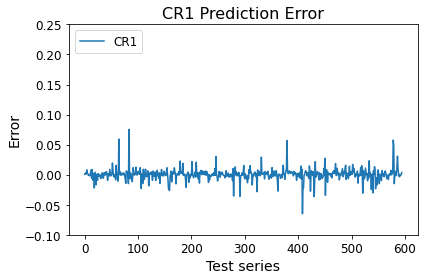

In [35]:
plot_PredictionError([-0.1,0.25],ind=0)

Saving figure au150_DW_ann_chi_cr1_200_20_1_run_2022_05_28-15_27_10_prediction_error_2


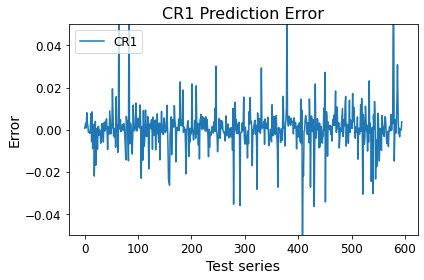

In [36]:
plot_PredictionError([-0.05,0.05],ind=2)

#### 直接比较

Saving figure au150_DW_ann_chi_cr1_200_20_1_run_2022_05_28-15_27_10_prediction_compare_CR1


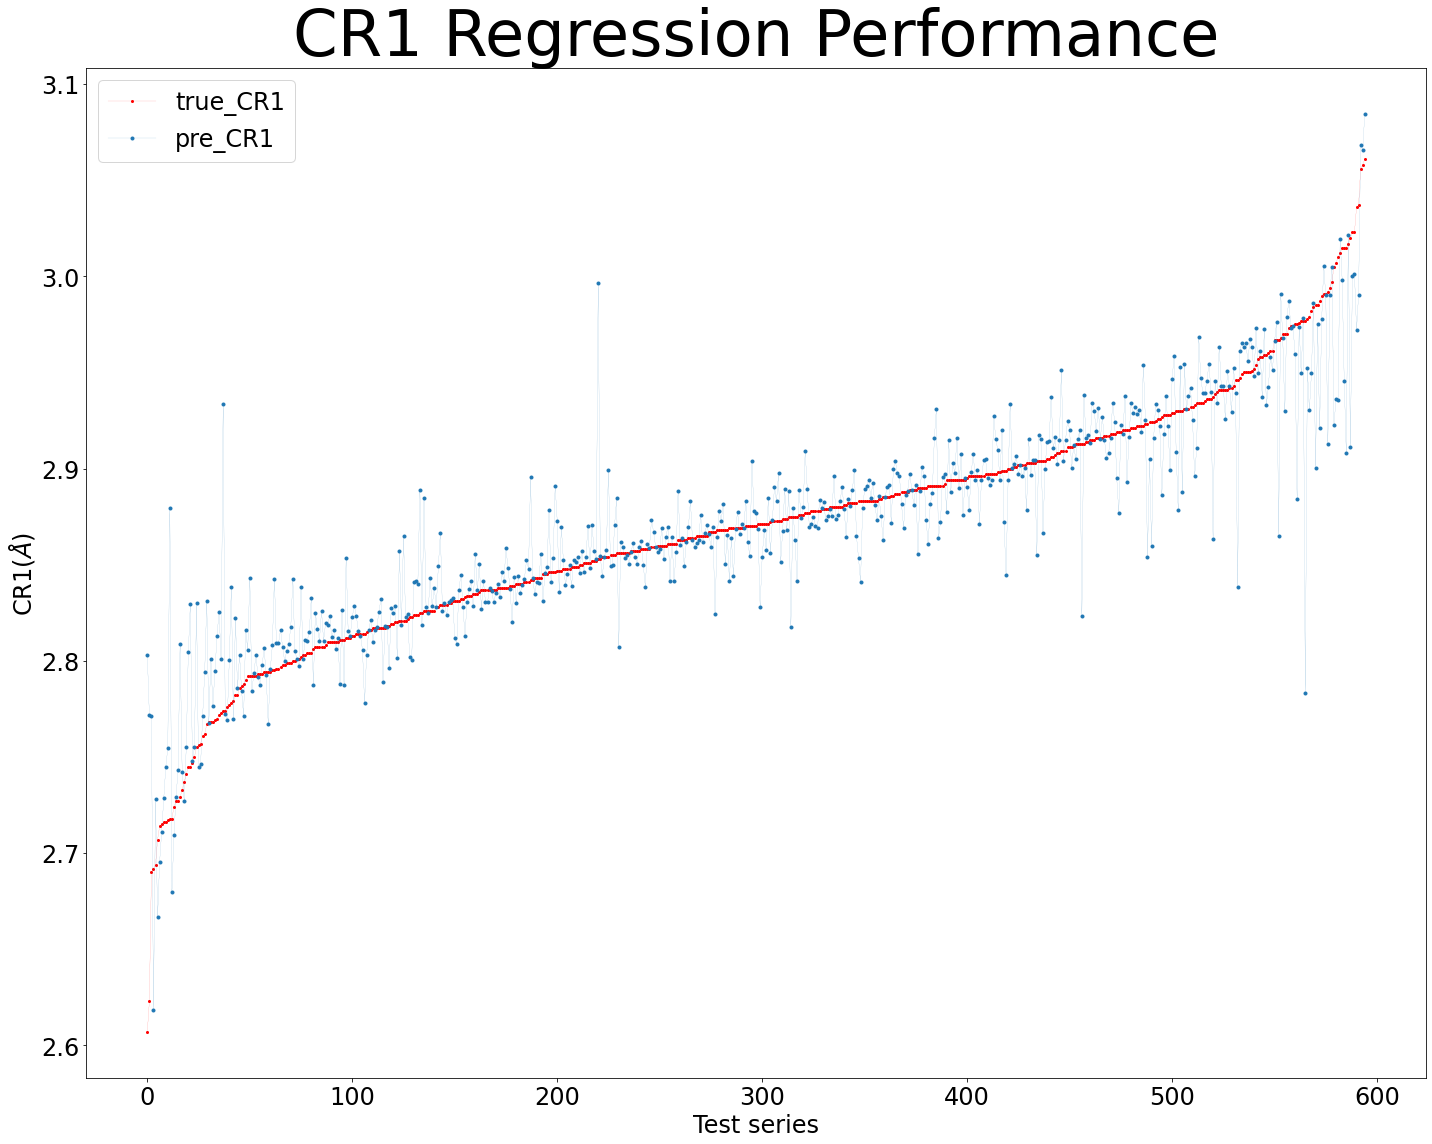

In [37]:
prediction_compare = file_pre + f"_prediction_compare_{label_index}"
x = range(pre.shape[0])
plt.figure(figsize = (20, 16))
plt.plot(x,label_test.flatten()[label_test.flatten().argsort()],'o-',color='r',linewidth = 0.1,markersize=2,label=f"true_{label_index}")
plt.plot(x,pre.flatten()[label_test.flatten().argsort()],'o-',linewidth = 0.1,markersize=3,label=f"pre_{label_index}")
plt.xlabel('Test series',fontsize=24)
plt.ylabel(f'{label_index}($\AA$)',fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(loc='upper left', fontsize=24)
plt.title(f"{label_index} Regression Performance", fontsize=64)
save_fig(path_ana_work, prediction_compare)

Saving figure au150_DW_ann_chi_cr1_200_20_1_run_2022_05_28-15_27_10_prediction_compare_CR1_2


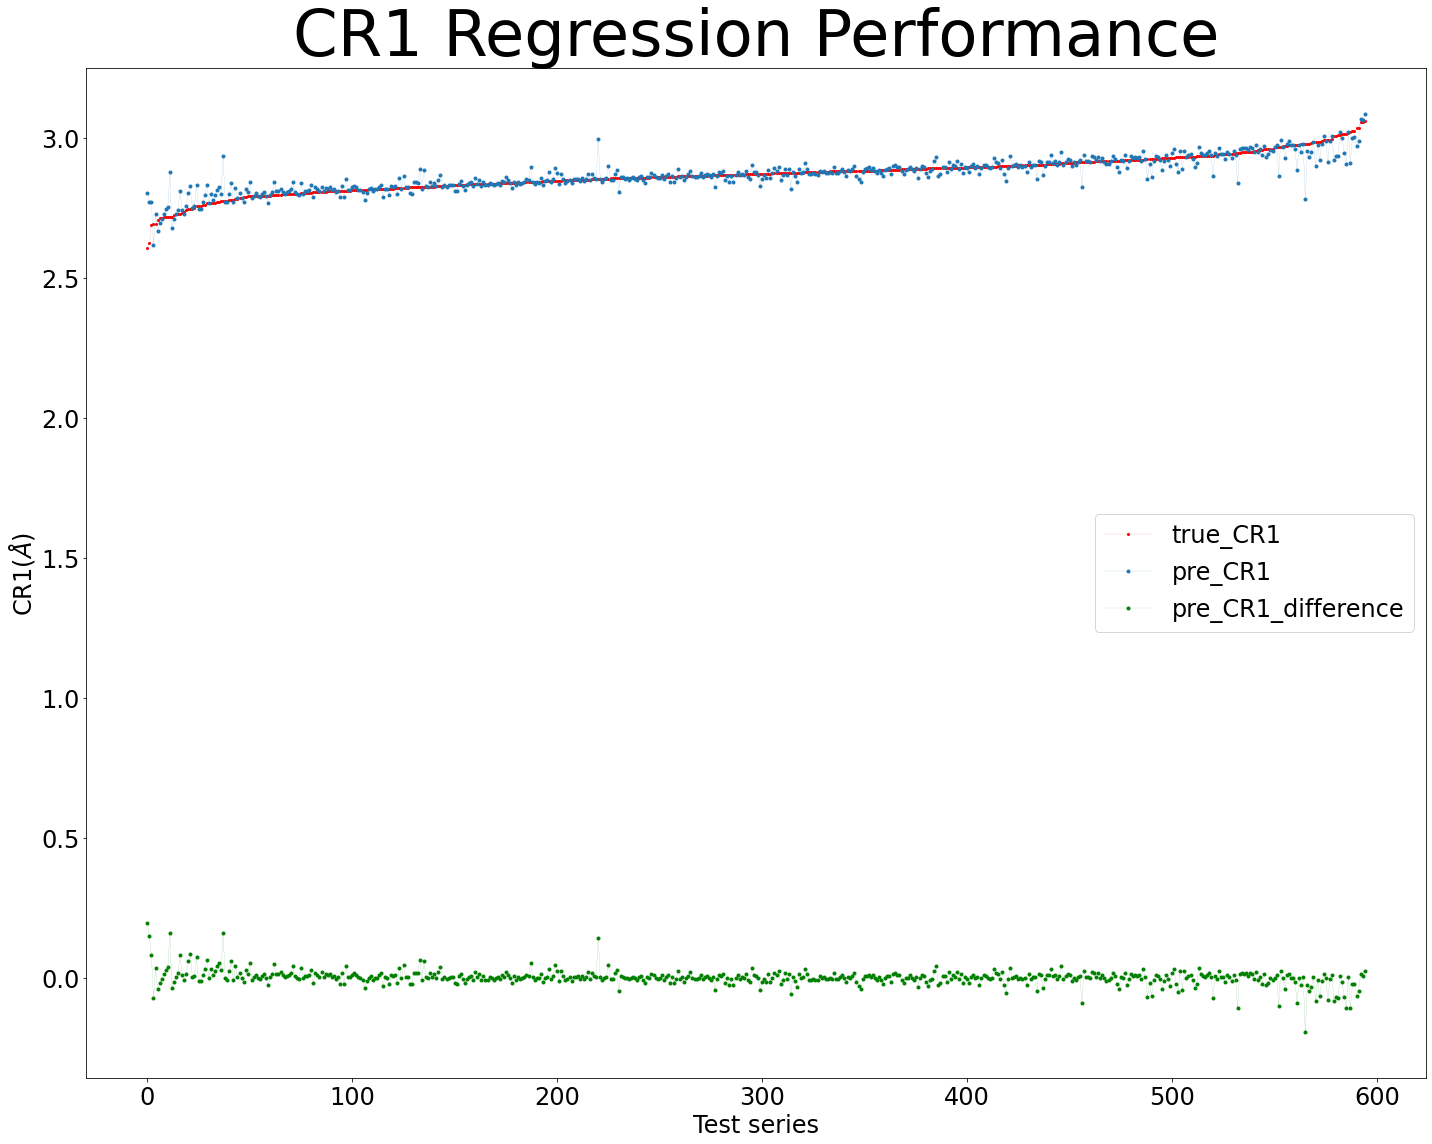

In [38]:
prediction_compare = file_pre + f"_prediction_compare_{label_index}_2"
x = range(pre.shape[0])
plt.figure(figsize = (20, 16))
plt.plot(x,label_test.flatten()[label_test.flatten().argsort()],'o-',color='r',linewidth = 0.1,markersize=2,label=f"true_{label_index}")
plt.plot(x,pre.flatten()[label_test.flatten().argsort()],'o-',linewidth = 0.1,markersize=3,label=f"pre_{label_index}")
plt.plot(x,diff.flatten()[label_test.flatten().argsort()],'o-',color='green',linewidth = 0.1,markersize=3,label=f"pre_{label_index}_difference")
plt.xlabel('Test series',fontsize=24)
plt.ylabel(f'{label_index}($\AA$)',fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=24)
plt.title(f"{label_index} Regression Performance", fontsize=64)
save_fig(path_ana_work, prediction_compare)

Saving figure au150_DW_ann_chi_cr1_200_20_1_run_2022_05_28-15_27_10_prediction_compare_CR1_3


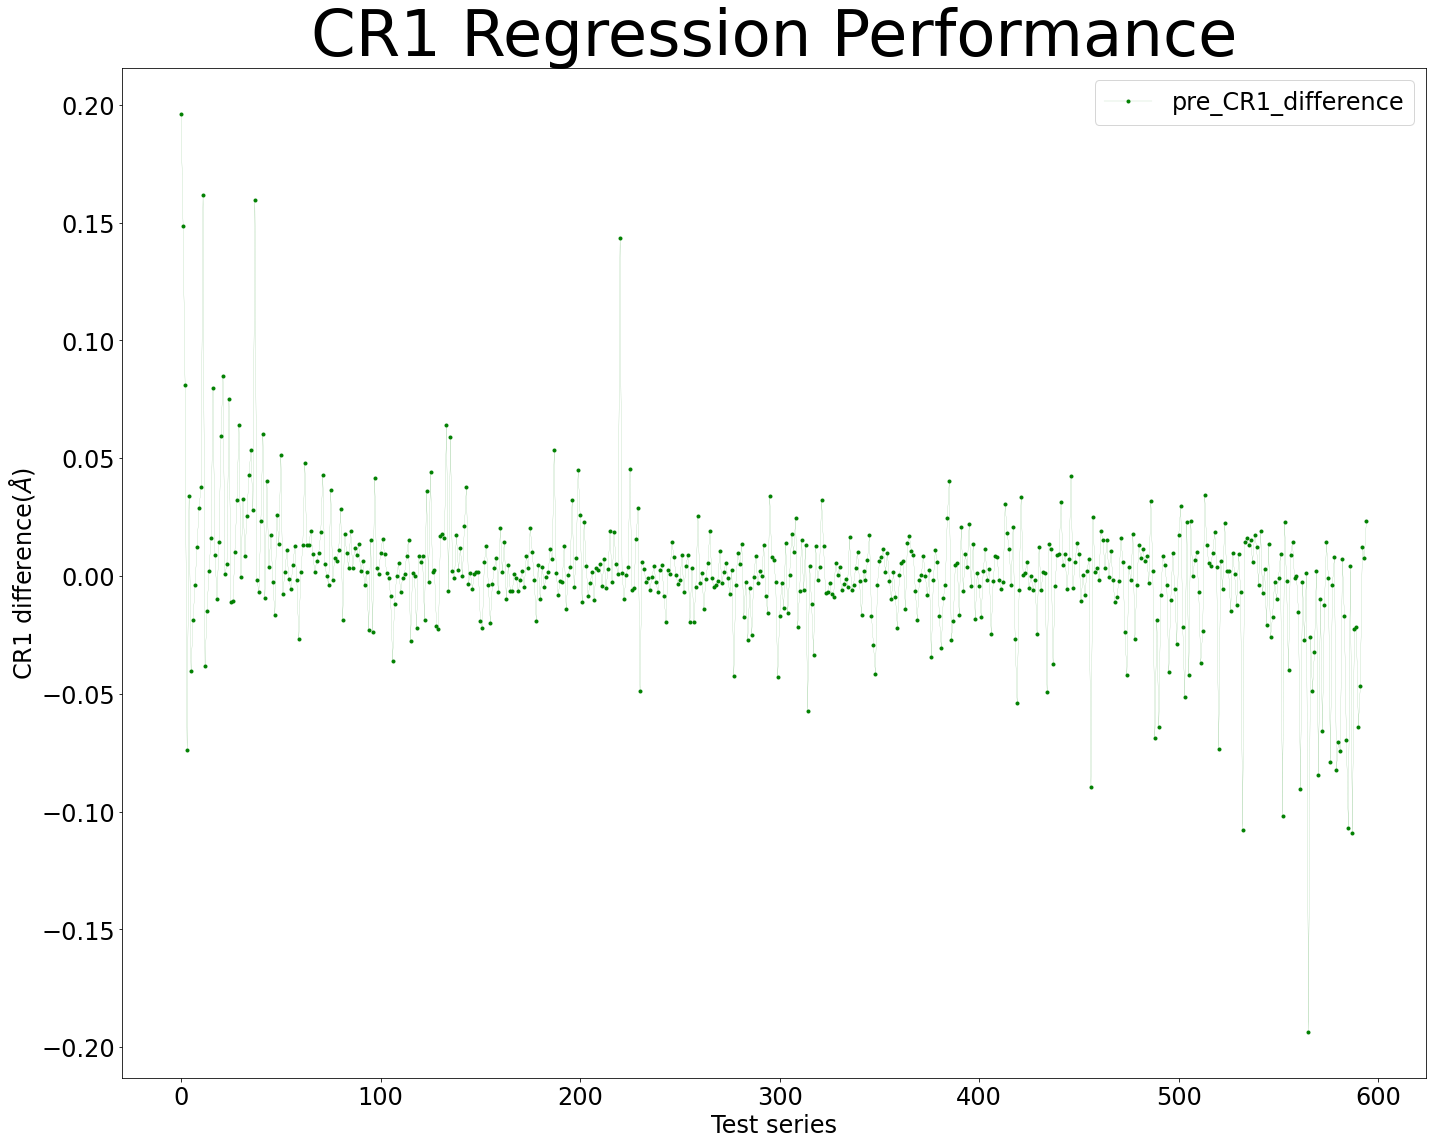

In [39]:
prediction_compare = file_pre + f"_prediction_compare_{label_index}_3"
x = range(pre.shape[0])
plt.figure(figsize = (20, 16))
plt.plot(x,diff.flatten()[label_test.flatten().argsort()],'o-',color='green',linewidth = 0.1,markersize=3,label=f"pre_{label_index}_difference")
plt.xlabel('Test series',fontsize=24)
plt.ylabel(f'{label_index} difference($\AA$)',fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=24)
plt.title(f"{label_index} Regression Performance", fontsize=64)
save_fig(path_ana_work, prediction_compare)

#### 分段直接比较

In [40]:
def plot_PredictionCompare(x_low, x_high, x_ticks=10):
    """
    """
#
    prediction_compare = file_pre + f"_prediction_compare_{label_index}_{x_low}_{x_high}"
    x = range(pre.shape[0])
    plt.figure(figsize=(8, 8))
    plt.scatter(x,label_test, marker='o', s=50, label = f'{label_index}')  # s为标记大小
    plt.scatter(x,pre, marker='^', s=50, label = f'{label_index}_pre')
    plt.xlabel('Test series')
    plt.ylabel(f'{label_index}($\AA$)')
    plt.xlim(x_low,x_high)
    ylim_min0 = min(np.min(label_test[x_low:x_high]),np.min(pre[x_low:x_high]))
    ylim_max0 = max(np.max(label_test[x_low:x_high]),np.max(pre[x_low:x_high]))
    ylim_len = (ylim_max0 - ylim_min0)*1.1
    ylim_min = (ylim_min0 + ylim_max0)/2 - ylim_len/2
    ylim_max = (ylim_min0 + ylim_max0)/2 + ylim_len/2
    plt.ylim(ylim_min, ylim_max)
    plt.xticks(np.arange(x_low,x_high+1,x_ticks), rotation=0)#rotation控制倾斜角度
#plt.yticks(np.arange(np.max(label_test)-1, np.max(label_test)+1, 2))
#plt.yticks(np.arange(np.around(np.min(label_test),1)-0.1, np.around(np.max(label_test),1)+0.1, 0.2))
#    plt.legend(loc='upper right', fontsize=12)
    plt.legend(fontsize=12)
    plt.title(f"{label_index} Regression Performance", fontsize=16)
    save_fig(path_cn_work, prediction_compare)

Saving figure au150_DW_ann_chi_cr1_200_20_1_run_2022_05_28-15_27_10_prediction_compare_CR1_0_50
Saving figure au150_DW_ann_chi_cr1_200_20_1_run_2022_05_28-15_27_10_prediction_compare_CR1_50_100
Saving figure au150_DW_ann_chi_cr1_200_20_1_run_2022_05_28-15_27_10_prediction_compare_CR1_100_150
Saving figure au150_DW_ann_chi_cr1_200_20_1_run_2022_05_28-15_27_10_prediction_compare_CR1_150_200
Saving figure au150_DW_ann_chi_cr1_200_20_1_run_2022_05_28-15_27_10_prediction_compare_CR1_200_250
Saving figure au150_DW_ann_chi_cr1_200_20_1_run_2022_05_28-15_27_10_prediction_compare_CR1_250_300
Saving figure au150_DW_ann_chi_cr1_200_20_1_run_2022_05_28-15_27_10_prediction_compare_CR1_300_350
Saving figure au150_DW_ann_chi_cr1_200_20_1_run_2022_05_28-15_27_10_prediction_compare_CR1_350_400
Saving figure au150_DW_ann_chi_cr1_200_20_1_run_2022_05_28-15_27_10_prediction_compare_CR1_400_450
Saving figure au150_DW_ann_chi_cr1_200_20_1_run_2022_05_28-15_27_10_prediction_compare_CR1_450_500
Saving figure 

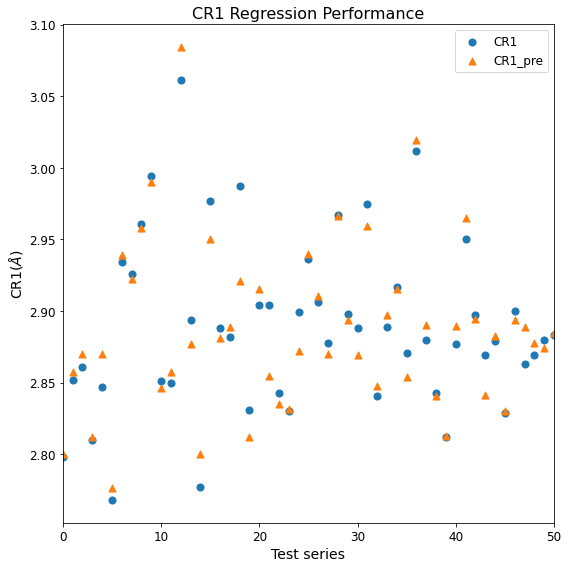

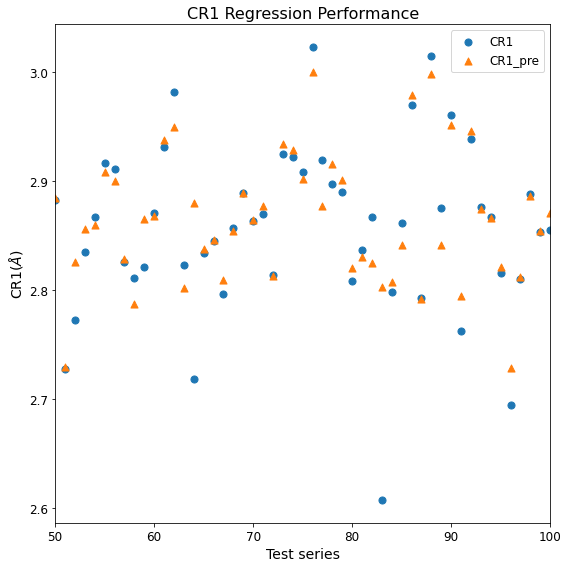

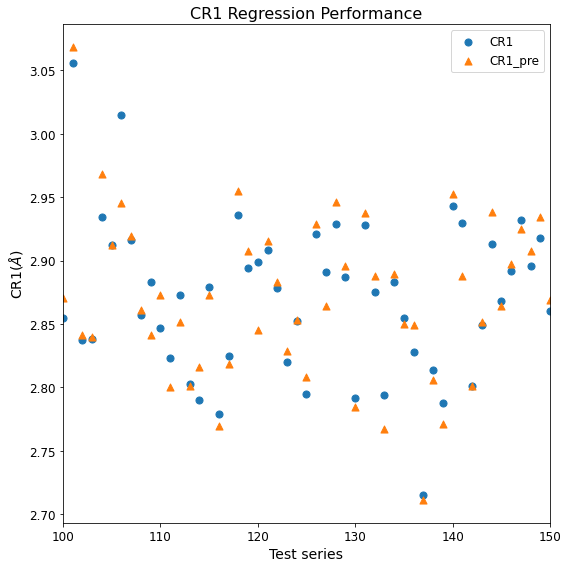

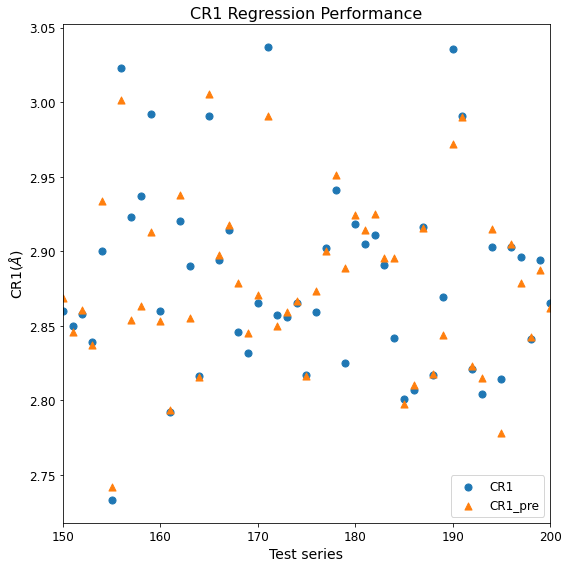

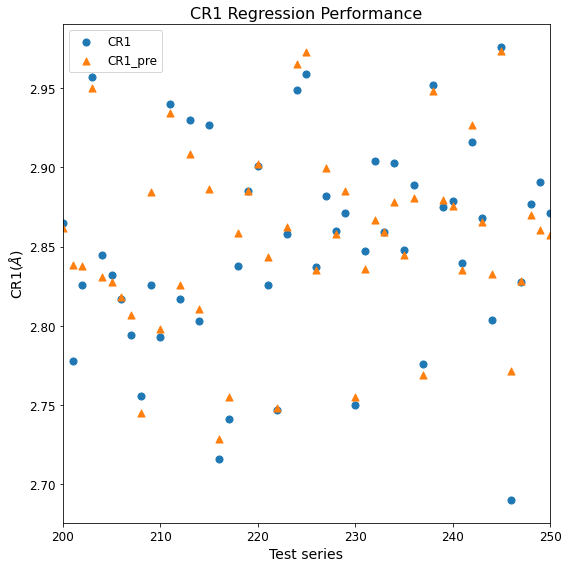

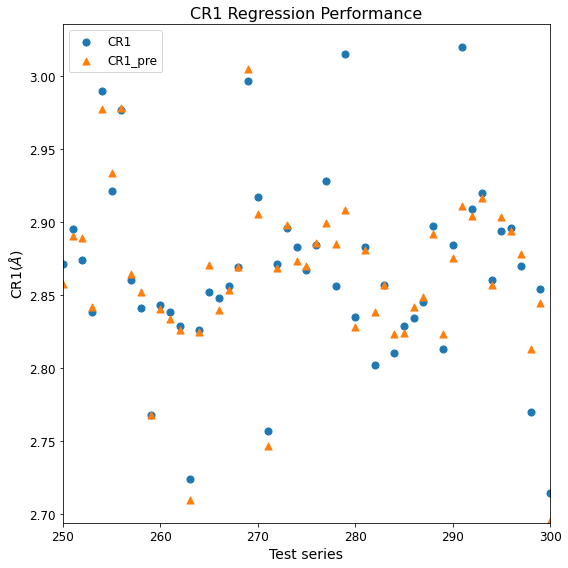

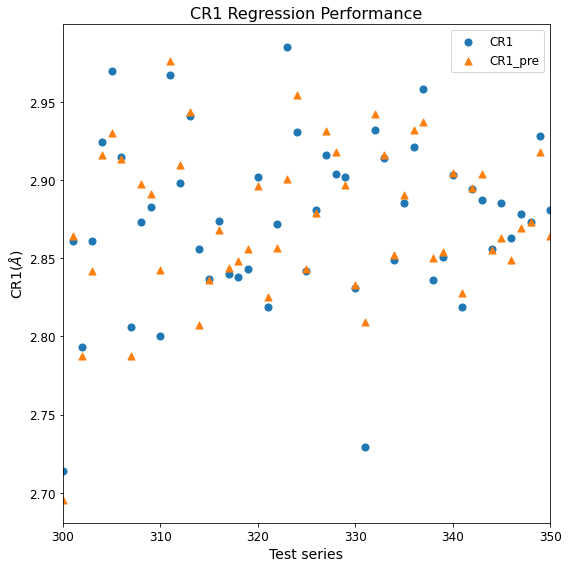

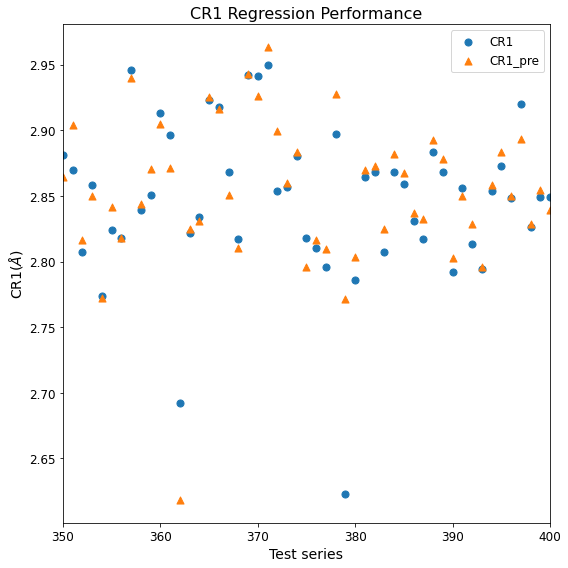

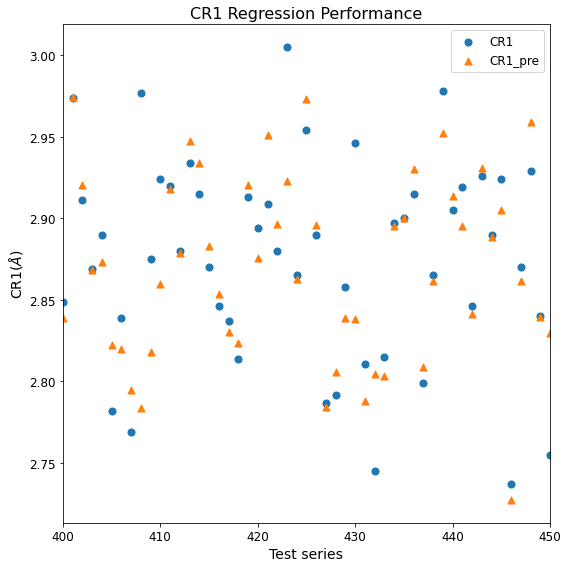

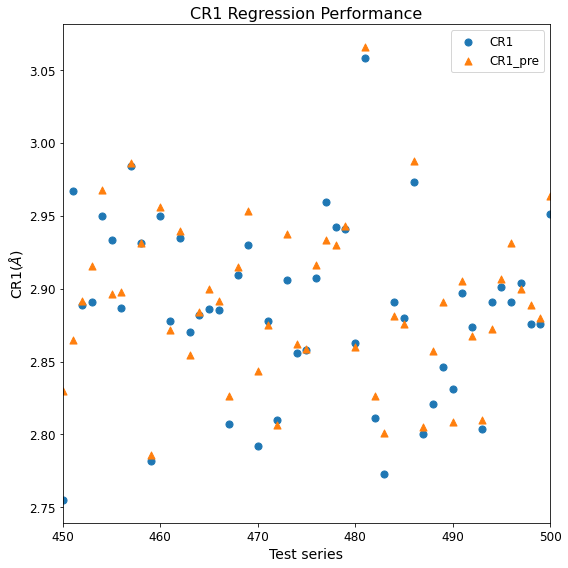

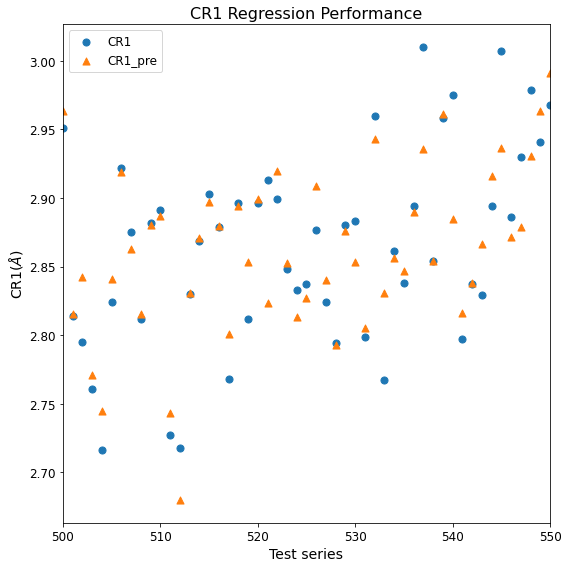

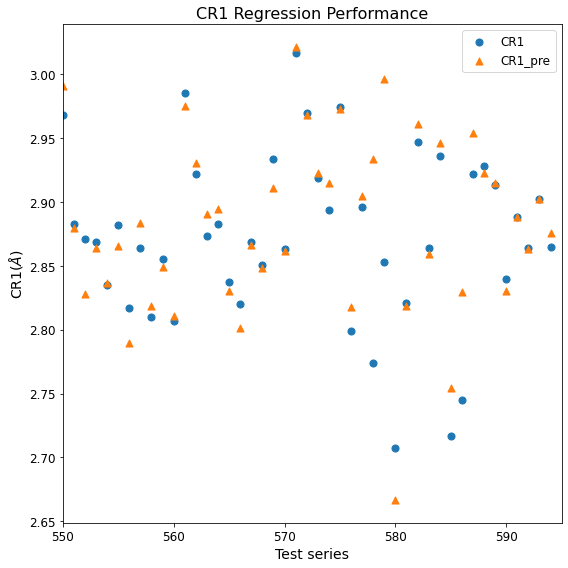

In [41]:
interval = 50
for i in range(0,pre.size, interval):
    plot_PredictionCompare(i, min(i+interval, pre.size))

###### 不同颜色（线条）

In [42]:
def plot_PredictionCompare2(x_low, x_high, x_ticks=10):
    """
    """
#
    prediction_compare = file_pre + f"_prediction_compare2_{label_index}_{x_low}_{x_high}"
    x = range(pre.shape[0])
    plt.figure(figsize=(10, 8))
    plt.plot(x,label_test, 'o-', markersize= 8, linewidth = 0.7, label = f'{label_index}')
    plt.plot(x,pre, '^-', color='red', markersize=8, linewidth = 0.7, label = f'{label_index}_pre')
    plt.xlabel('Test series')
    plt.ylabel(f'{label_index}($\AA$)')
    plt.xlim(x_low,x_high)
    ylim_min0 = min(np.min(label_test[x_low:x_high]),np.min(pre[x_low:x_high]))
    ylim_max0 = max(np.max(label_test[x_low:x_high]),np.max(pre[x_low:x_high]))
    ylim_len = (ylim_max0 - ylim_min0)*1.1
    ylim_min = (ylim_min0 + ylim_max0)/2 - ylim_len/2
    ylim_max = (ylim_min0 + ylim_max0)/2 + ylim_len/2
    plt.ylim(ylim_min, ylim_max)
    plt.xticks(np.arange(x_low,x_high+1,x_ticks), rotation=0)#rotation控制倾斜角度
#    plt.yticks(np.arange(np.around(np.min(label_test),1)-0.1, np.around(np.max(label_test),1)+0.1, 0.2))
#    plt.legend(loc='upper right', fontsize=12)
    plt.legend(fontsize=12)
    plt.title(f"{label_index} Regression Performance", fontsize=16)
    save_fig(path_cn_work, prediction_compare)

Saving figure au150_DW_ann_chi_cr1_200_20_1_run_2022_05_28-15_27_10_prediction_compare2_CR1_0_50
Saving figure au150_DW_ann_chi_cr1_200_20_1_run_2022_05_28-15_27_10_prediction_compare2_CR1_50_100
Saving figure au150_DW_ann_chi_cr1_200_20_1_run_2022_05_28-15_27_10_prediction_compare2_CR1_100_150
Saving figure au150_DW_ann_chi_cr1_200_20_1_run_2022_05_28-15_27_10_prediction_compare2_CR1_150_200
Saving figure au150_DW_ann_chi_cr1_200_20_1_run_2022_05_28-15_27_10_prediction_compare2_CR1_200_250
Saving figure au150_DW_ann_chi_cr1_200_20_1_run_2022_05_28-15_27_10_prediction_compare2_CR1_250_300
Saving figure au150_DW_ann_chi_cr1_200_20_1_run_2022_05_28-15_27_10_prediction_compare2_CR1_300_350
Saving figure au150_DW_ann_chi_cr1_200_20_1_run_2022_05_28-15_27_10_prediction_compare2_CR1_350_400
Saving figure au150_DW_ann_chi_cr1_200_20_1_run_2022_05_28-15_27_10_prediction_compare2_CR1_400_450
Saving figure au150_DW_ann_chi_cr1_200_20_1_run_2022_05_28-15_27_10_prediction_compare2_CR1_450_500
Savi

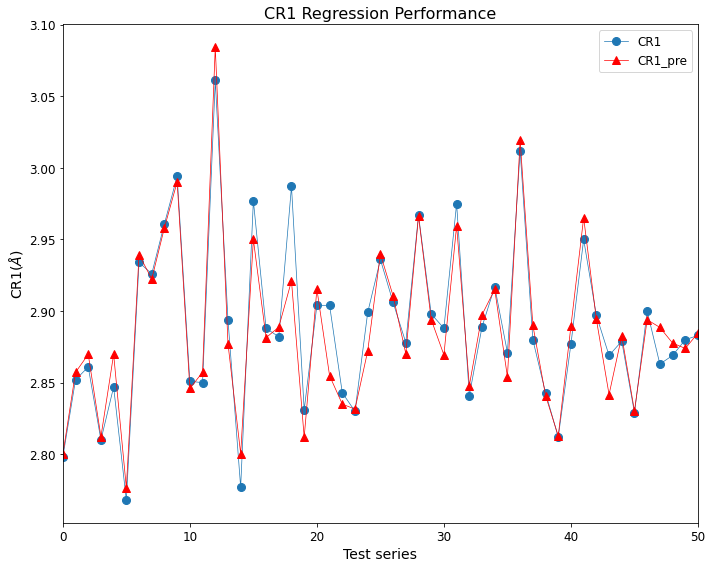

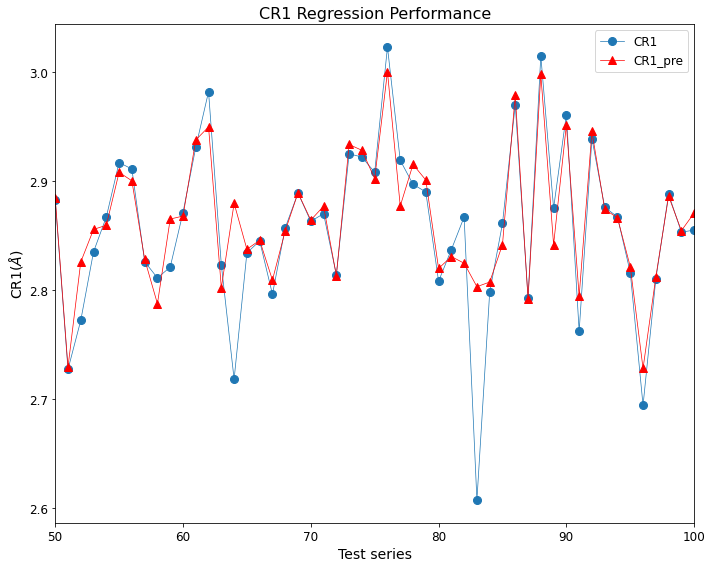

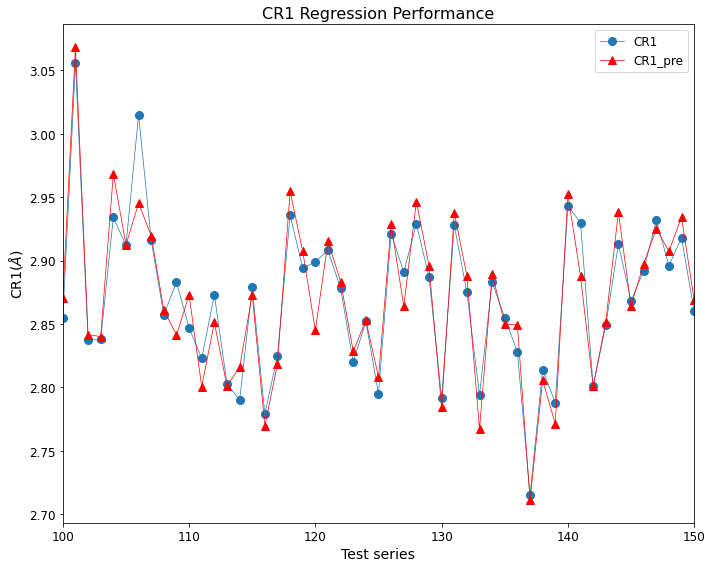

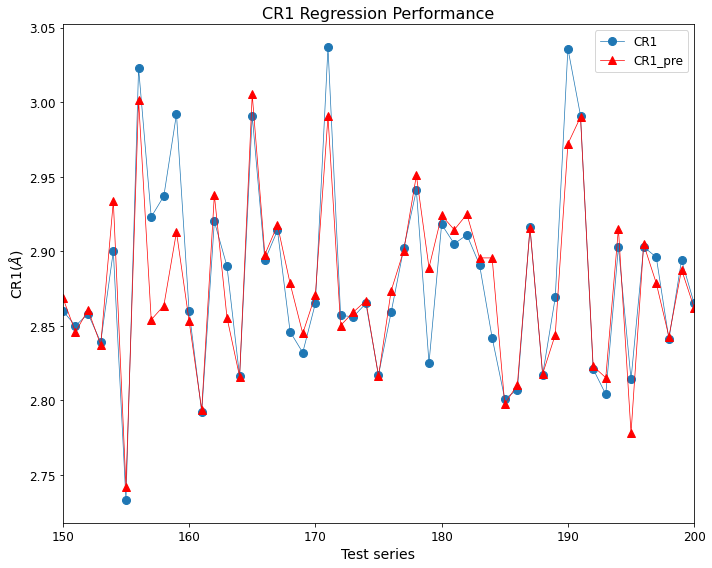

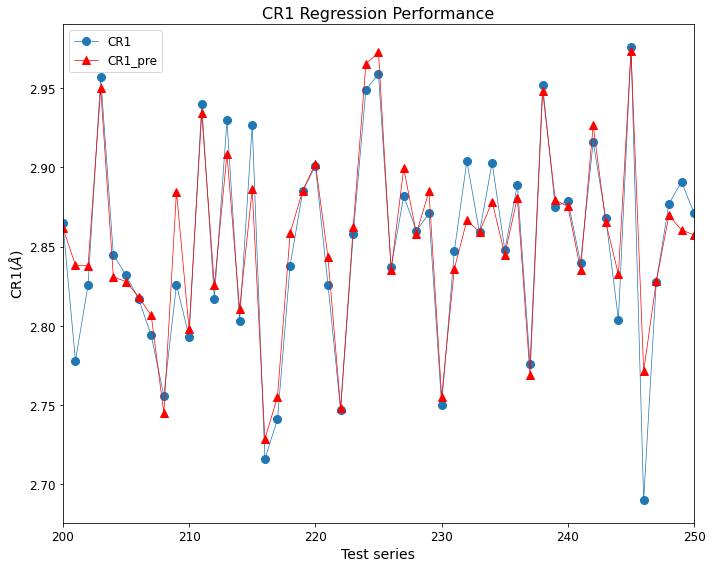

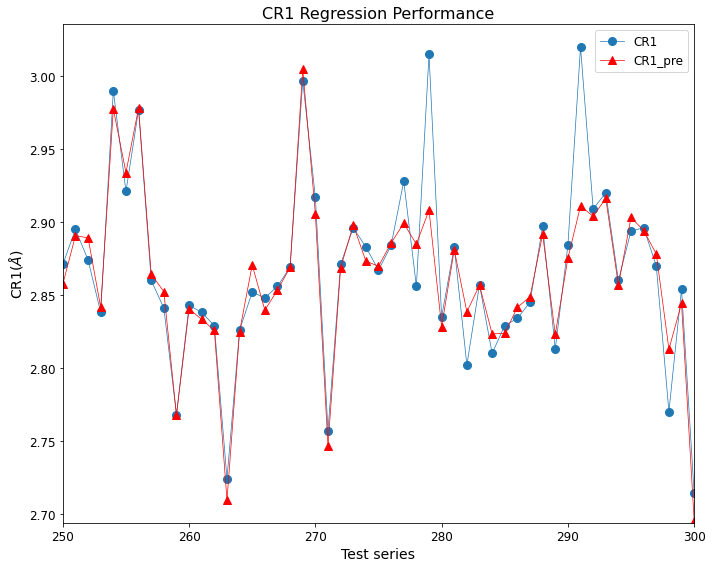

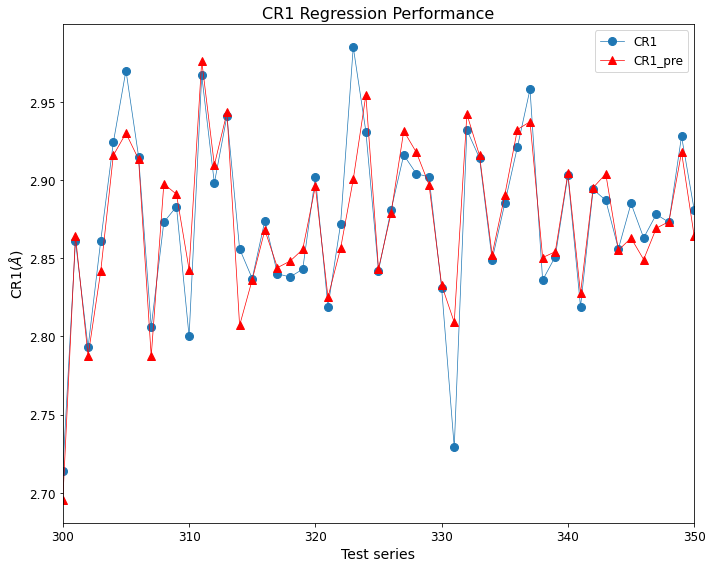

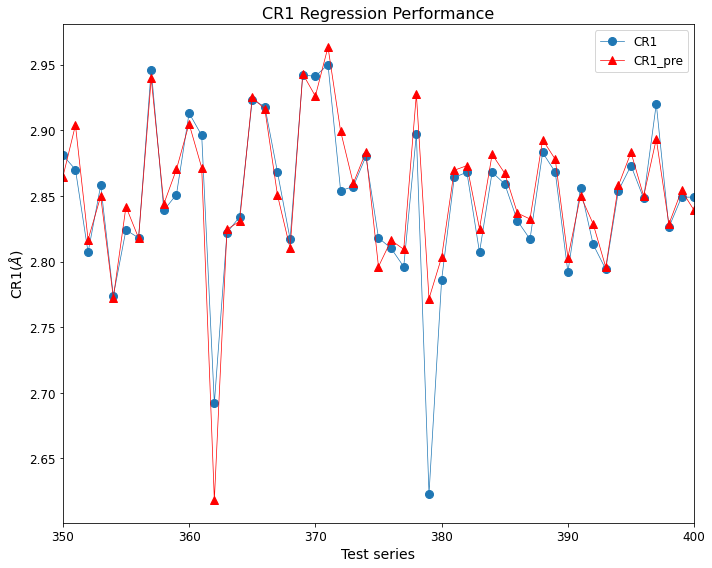

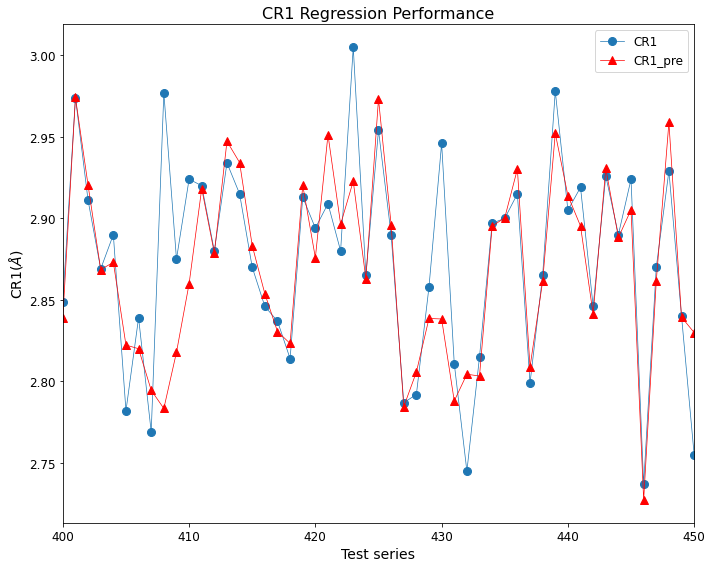

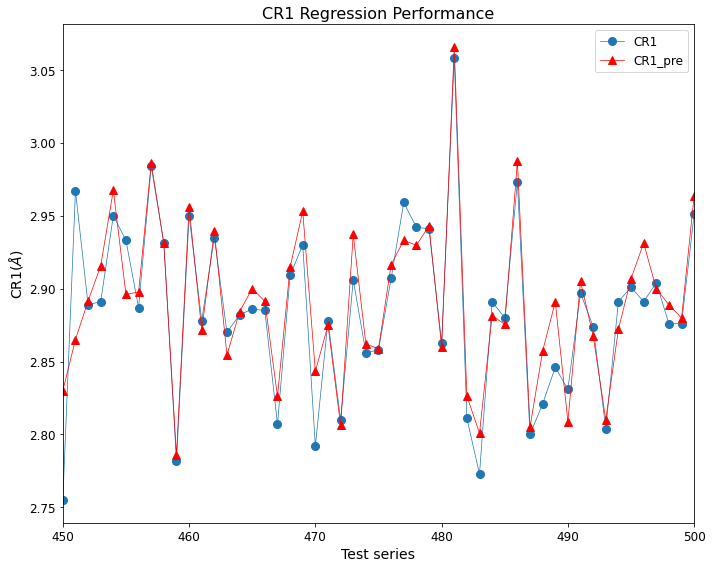

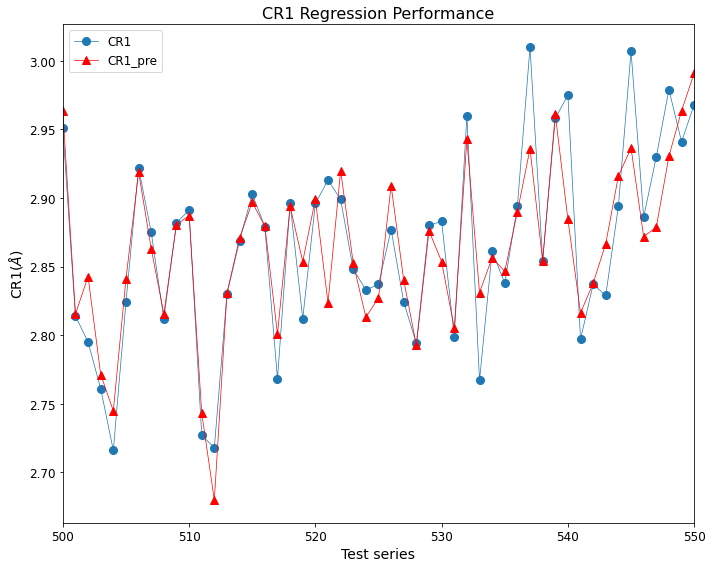

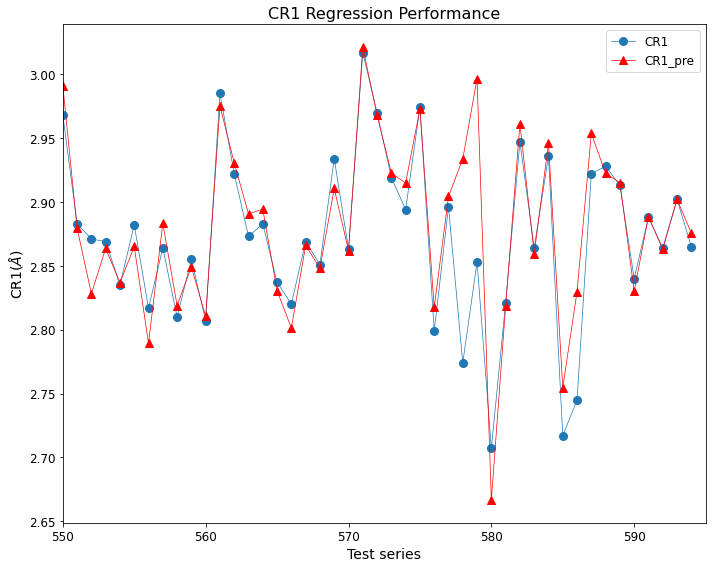

In [43]:
interval = 50
for i in range(0,pre.size, interval):
    plot_PredictionCompare2(i, min(i+interval, pre.size))

#### 想画哪个就画哪个

In [44]:
# x_low and x_high are the border of x-axis for plotting
x_low = 0
x_high = 100
# x_ticks is the step show for x-axis plottong
x_ticks = 10

In [45]:
def plot_PredictionCompare3(x_low, x_high, x_ticks=10):
    """
    """
#
    prediction_compare = file_pre + f"_prediction_compare3_{label_index}_{x_low}_{x_high}"
    x = range(pre.shape[0])
    plt.figure(figsize = (10, 8))
    plt.plot(x,label_test.flatten()[label_test.flatten().argsort()],'o-',color='r',linewidth = 0.1,markersize=2,label=f"true_{label_index}")
    plt.plot(x,pre.flatten()[label_test.flatten().argsort()],'o-',linewidth = 0.1,markersize=3,label=f"pre_{label_index}")
    plt.xlabel('Test series')
    plt.ylabel(f'{label_index}($\AA$)')
    plt.xlim(x_low,x_high)
    plt.xticks(np.arange(x_low,x_high+1,x_ticks), rotation=0)#rotation控制倾斜角度
#plt.yticks(np.arange(0, np.max(label_test)+1, 2))
    plt.legend(loc='upper left', fontsize=12)
    plt.title(f"{label_index} Regression Performance", fontsize=16)
    save_fig(path_ana_work, prediction_compare)

Saving figure au150_DW_ann_chi_cr1_200_20_1_run_2022_05_28-15_27_10_prediction_compare3_CR1_0_100


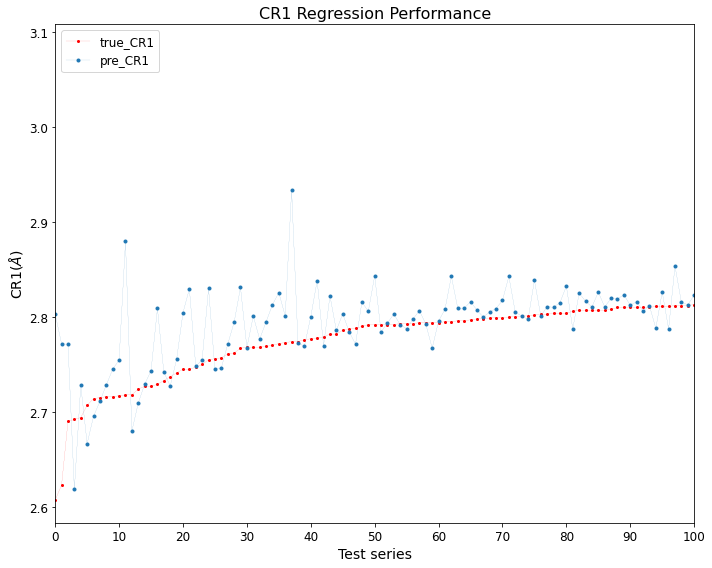

In [46]:
plot_PredictionCompare3(x_low, x_high, x_ticks)

#### parity chart for label

Saving figure au150_DW_ann_chi_cr1_200_20_1_run_2022_05_28-15_27_10_parity


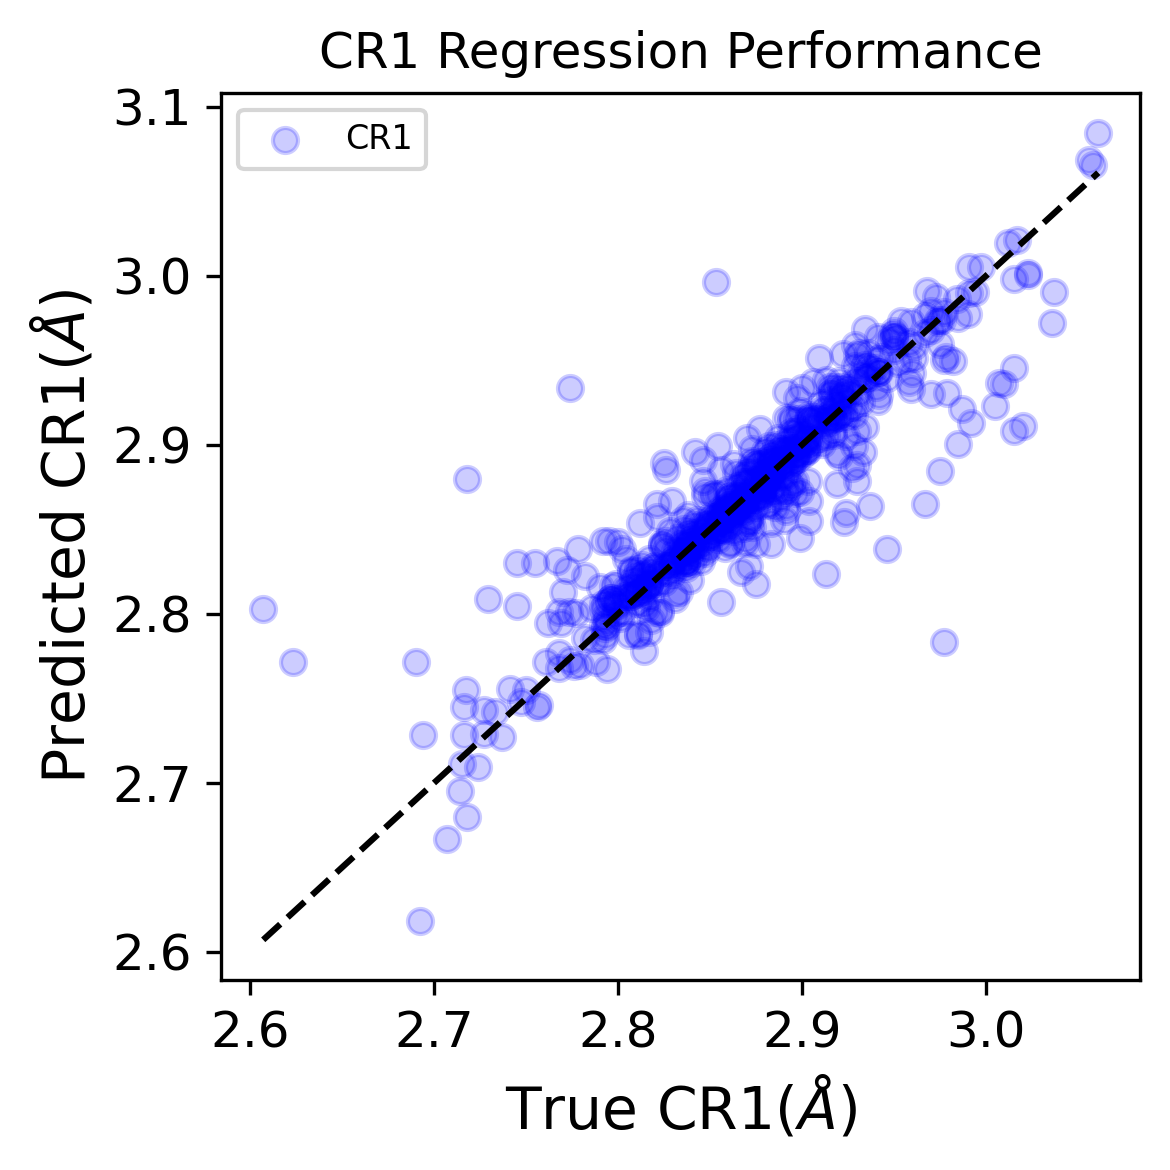

In [47]:
fig_parity = file_pre + '_parity'
number = pre.shape[0]
#
plt.figure(figsize=(4,4),dpi=300)
plt.scatter(label_test.flatten()[0],
            pre.flatten()[0],
            zorder = -1,
            marker = 'o',
            color = 'blue', 
            alpha = 0.2,
            label = label_index)
#
for i in range(number)[1:]:
    plt.scatter(label_test.flatten()[i],
                pre.flatten()[i],
                zorder = np.random.uniform(0,1),
                marker = 'o',
                color = 'blue', 
#                alpha = 100/number,
                alpha = 0.2)
#
a = np.min(label_test)
b = np.max(label_test)
plt.plot((a, b),(a, b),color='black',ls='--')
plt.legend(fontsize=8)
plt.title(f"{label_index} Regression Performance",fontsize=12)
plt.xlabel(f"True {label_index}($\AA$)")
plt.ylabel(f"Predicted {label_index}($\AA$)")
#plt.xticks(np.arange(a,b,0.1), rotation=0)#rotation控制倾斜角度
#plt.yticks(np.arange(a,b,0.1))
save_fig(path_ana_work, fig_parity)

#### Distribution for label predict difference

Saving figure au150_DW_ann_chi_cr1_200_20_1_run_2022_05_28-15_27_10_parity_difference


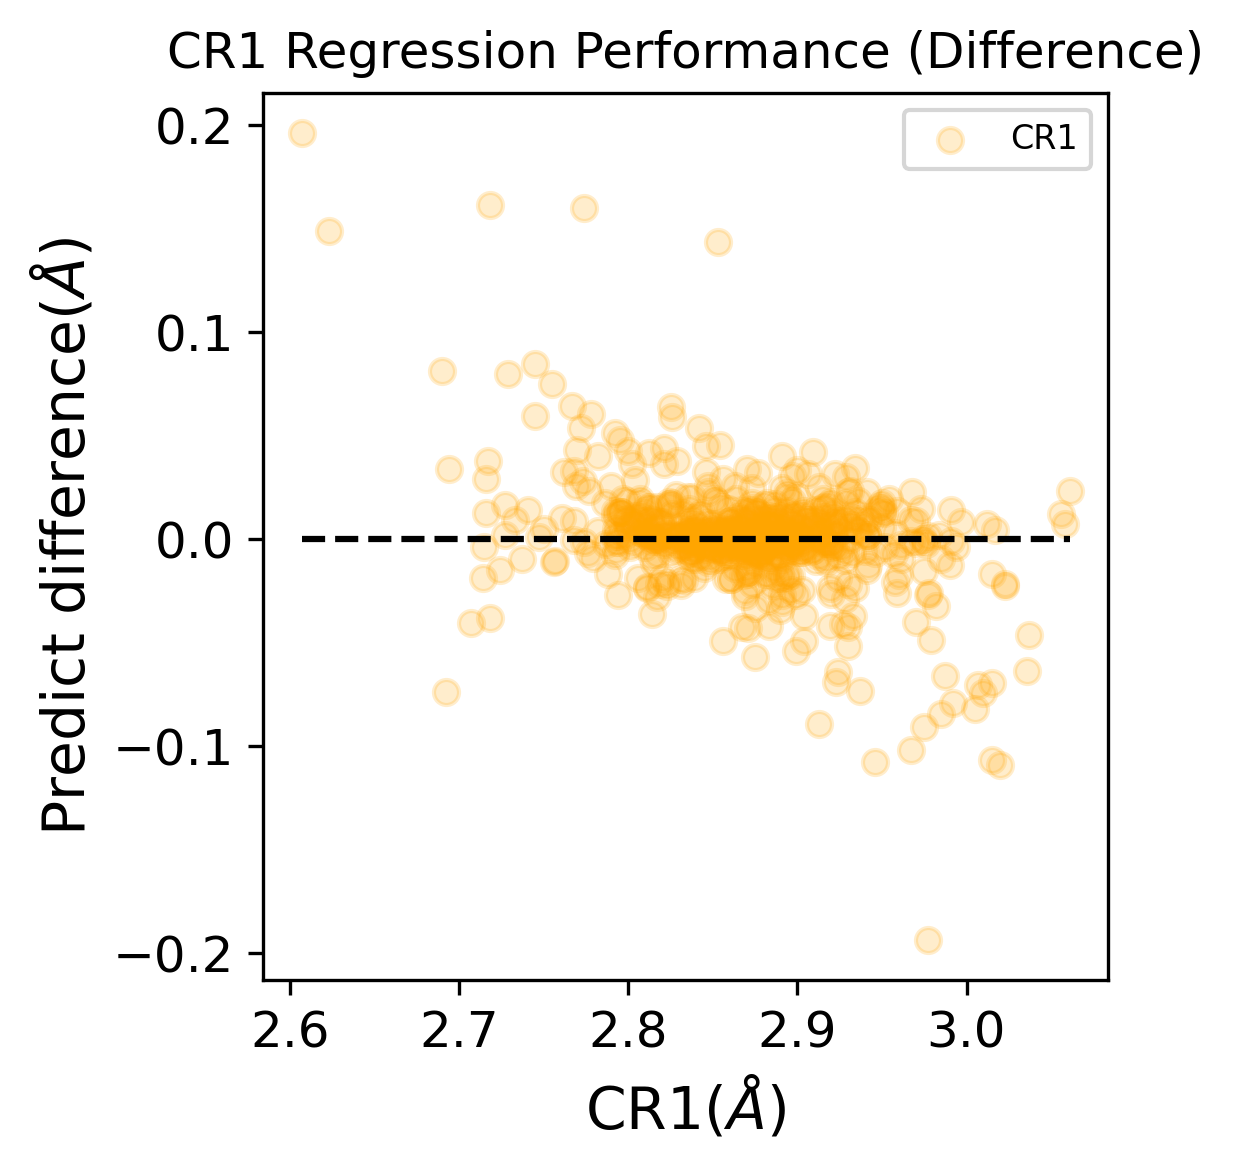

In [48]:
fig_diff = file_pre + '_parity' + '_difference'
number = pre.shape[0]
#
plt.figure(figsize=(4,4),dpi=300)
plt.scatter(label_test.flatten()[0],
            diff.flatten()[0],
            zorder = -1,
            marker = 'o',
            color = 'orange', 
            alpha = 0.2,
            label = label_index)
#
for i in range(number)[1:]:
    plt.scatter(label_test.flatten()[i],
                diff.flatten()[i],
                zorder = np.random.uniform(0,1),
                marker = 'o',
                color = 'orange', 
#                alpha = 100/number,
                alpha = 0.2)
#
a = np.min(label_test)
b = np.max(label_test)
plt.plot((a, b),(0, 0),color='black',ls='--')
plt.legend(fontsize=8)
plt.title(f"{label_index} Regression Performance (Difference)",fontsize=12)
plt.xlabel(f"{label_index}($\AA$)")
plt.ylabel(f"Predict difference($\AA$)")
#plt.xticks(np.arange(a,b,0.1), rotation=0)#rotation控制倾斜角度
#plt.yticks(np.arange(a,b,0.1))
save_fig(path_ana_work, fig_diff)

#### Distribution for CN error

Saving figure au150_DW_ann_chi_cr1_200_20_1_run_2022_05_28-15_27_10_parity_error


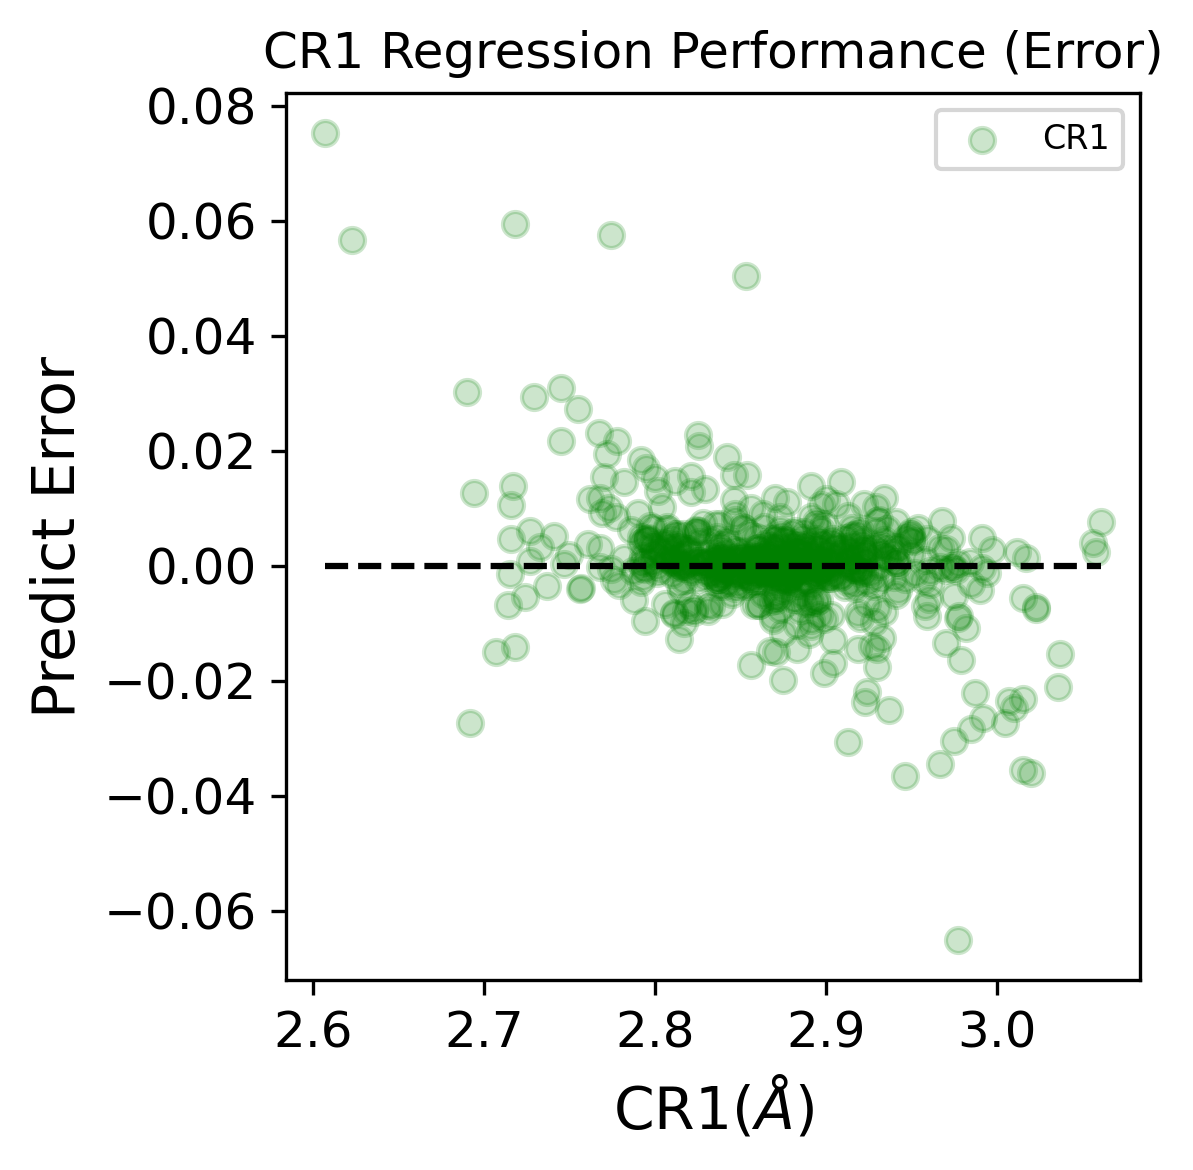

In [49]:
fig_err = file_pre + '_parity' + '_error'
number = pre.shape[0]
#
plt.figure(figsize=(4,4),dpi=300)
plt.scatter(label_test.flatten()[0],
            err.flatten()[0],
            zorder = -1,
            marker = 'o',
            color = 'green', 
            alpha = 0.2,
            label = label_index)
#
for i in range(number)[1:]:
    plt.scatter(label_test.flatten()[i],
                err.flatten()[i],
                zorder = np.random.uniform(0,1),
                marker = 'o',
                color = 'green', 
#                alpha = 100/number,
                alpha = 0.2)
#
a = np.min(label_test)
b = np.max(label_test)
plt.plot((a, b),(0, 0),color='black',ls='--')
plt.legend(fontsize=8)
plt.title(f"{label_index} Regression Performance (Error)",fontsize=12)
plt.xlabel(f"{label_index}($\AA$)")
plt.ylabel(f"Predict Error")
#plt.xticks(np.arange(a,b,0.1), rotation=0)#rotation控制倾斜角度
#plt.yticks(np.arange(a,b,0.1))
save_fig(path_ana_work, fig_err)

上图放大的情况，即将y轴取定范围。

Saving figure au150_DW_ann_chi_cr1_200_20_1_run_2022_05_28-15_27_10_parity_error_zoom


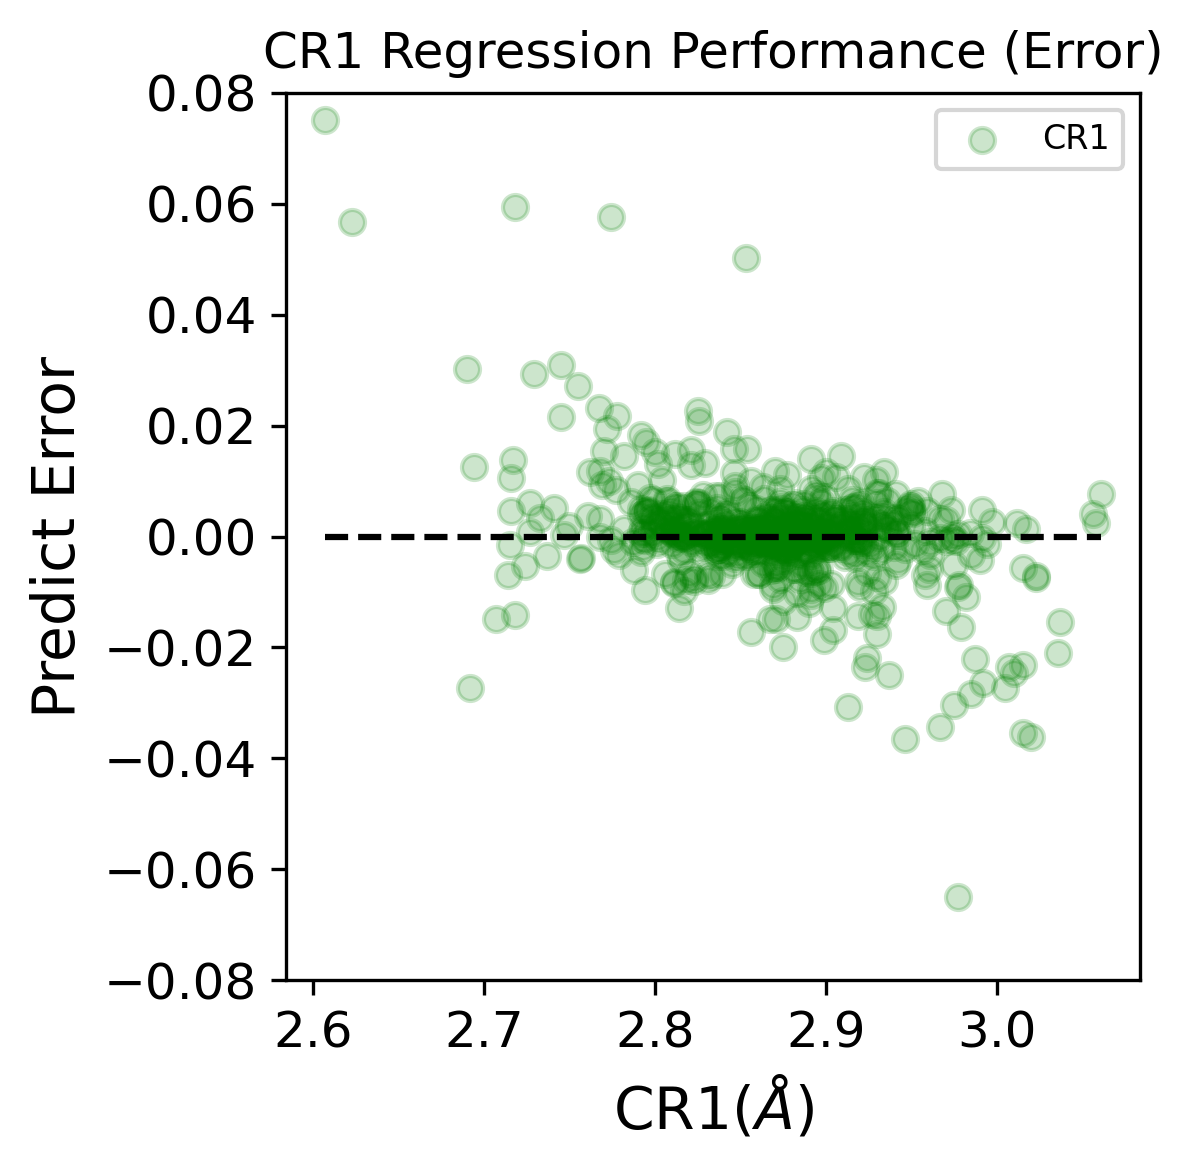

In [50]:
fig_err = file_pre + '_parity' + '_error_zoom'
number = pre.shape[0]
#
plt.figure(figsize=(4,4),dpi=300)
plt.scatter(label_test.flatten()[0],
            err.flatten()[0],
            zorder = -1,
            marker = 'o',
            color = 'green', 
            alpha = 0.2,
            label = label_index)
#
for i in range(number)[1:]:
    plt.scatter(label_test.flatten()[i],
                err.flatten()[i],
                zorder = np.random.uniform(0,1),
                marker = 'o',
                color = 'green', 
#                alpha = 100/number,
                alpha = 0.2)
#
a = np.min(label_test)
b = np.max(label_test)
plt.plot((a, b),(0, 0),color='black',ls='--')
plt.legend(fontsize=8)
plt.title(f"{label_index} Regression Performance (Error)",fontsize=12)
plt.xlabel(f"{label_index}($\AA$)")
plt.ylabel(f"Predict Error")
plt.ylim(-0.08,0.08)
#plt.xticks(np.arange(a,b,0.1), rotation=0)#rotation控制倾斜角度
#plt.yticks(np.arange(a,b,0.1))
save_fig(path_ana_work, fig_err)

注：若是配位键长预测，只需在上述代码中修改模型文件、label_index和label_test即可。注意图形绘制时的步长要做相应变化。

## 针对各个label（区间）进行分析

### 各个label（区间）分析

#### 基本设置

In [51]:
# label和预测值都是连续值，则需要先按照区间来进行划分统计
step_label = 0.05
step_pre = 0.05
digit_step_label = 2
digit_step_pre = 2
#
prf_step = f"_step={step_pre}"

#### 单个label细致统计

In [52]:
#  trivial用于避免计算机对边界数据处理不当导致的统计误差。
trivial = min(0.00001, step_label/100, step_pre/100)
#
label_max = np.max(label_test)
label_min = np.min(label_test)
pre_max = np.max(pre)
pre_min = np.min(pre)
#
dim_label_max = math.floor((label_max + trivial) / step_label)
dim_label_min = math.floor((label_min + trivial) / step_label)
dim_label = dim_label_max - dim_label_min + 1
dim_pre_max = math.floor((pre_max + trivial) / step_pre)
dim_pre_min = math.floor((pre_min + trivial) / step_pre)
dim_pre = dim_pre_max - dim_pre_min + 1
#
# PRE[i][j] 表示label值落在i区间（[(i+dim_label_min)*step_label,(i+1+dim_label_min)*step_label)），预测落到j区的个数
# PRE_min[i]和PRE_max[i]表示label值落在i区间，其预测分布区域的最小和最大j值
# label_list[i]表示label值落在区间i的样本在label_test中的预测值，它是一个列表。
# pre_index[i][j]表示label值落在区间i、预测值落到区间j的样本在label_test中的标号，它是一个列表；
# pre_list[i][j]表示label值落在区间i、预测值落到区间j的样本在label_test中的标号所对应的预测值，它也是一个列表。
# pre_diff_list[i][j]表示label值落在区间i、预测值落在区间j的样本在label_test中的标号所对应的diff值。它是一个列表。
# pre_diff_abs_list、pre_err_list、pre_err_abs_list意思同上。
PRE = np.zeros((dim_label, dim_pre),dtype=int)
PRE_max = []
PRE_min = []
label_list = []
pre_index = []
pre_list = []
pre_diff_list = []
pre_diff_abs_list = []
pre_err_list = []
pre_err_abs_list = []
for i in range(dim_label):
    PRE_max.append(0)
    PRE_min.append(dim_pre)
    label_list.append([])
    pre_index.append([])
    pre_list.append([])
    pre_diff_list.append([])
    pre_diff_abs_list.append([])
    pre_err_list.append([])
    pre_err_abs_list.append([])
    for j in range(dim_pre):
        pre_index[i].append([])
        pre_list[i].append([])
        pre_diff_list[i].append([])
        pre_diff_abs_list[i].append([])
        pre_err_list[i].append([])
        pre_err_abs_list[i].append([])
#
# 得到label_test从小到大排序的index列表
# label_test.flatten().argsort() = array([528, 272, ..., 11, 402], dtype=int64)
for i in label_test.flatten().argsort():
    m = math.floor((label_test[i][0] + trivial) / step_label) - dim_label_min
    n = math.floor((pre[i][0] + trivial) / step_pre) - dim_pre_min
    PRE[m][n] += 1
    PRE_max[m] = max(PRE_max[m],n)
    PRE_min[m] = min(PRE_min[m],n)
#
    label_list[m].append(label_test[i][0])
    pre_index[m][n].append(i)
    pre_list[m][n].append(pre[i][0])
    pre_diff_list[m][n].append(diff[i][0])
    pre_diff_abs_list[m][n].append(diff_abs[i][0])
    pre_err_list[m][n].append(err[i][0])
    pre_err_abs_list[m][n].append(err_abs[i][0])
# axis=0表示列求和，axis=1表示行求
# N_label[i]为label值落在区间i中的样本个数。
# N_pre[j] 为预测值落在区间j中的样本个数，
N_label = np.sum(PRE, axis=1)
N_pre = np.sum(PRE, axis=0)

去除PRE中无用的行（label）

In [53]:
# list_label、count_label为数列，其第i个元素为调整过的区间标号和计数
list_label = []
count_label = []
for i,j in enumerate(list(N_label)):
    if j != 0:
        list_label.append(i)
        count_label.append(j)

list_label = [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
count_label = [1, 1, 2, 3, 18, 47, 140, 209, 115, 44, 13, 4]

In [54]:
label_list_avg = [0] * dim_label
label_list_var = [0] * dim_label
label_list_std = [0] * dim_label
for i in list_label:
    label_list_avg[i] = np.mean(label_list[i])
    label_list_var[i] = np.var(label_list[i])
    label_list_std[i] = np.std(label_list[i])
#
pre_list_avg = [0] * dim_label
pre_list_var = [0] * dim_label
pre_list_std = [0] * dim_label
pre_diff_avg = [0] * dim_label
pre_diff_var = [0] * dim_label
pre_diff_std = [0] * dim_label
pre_diff_abs_avg = [0] * dim_label
pre_diff_abs_var = [0] * dim_label
pre_diff_abs_std = [0] * dim_label
pre_err_avg = [0] * dim_label
pre_err_var = [0] * dim_label
pre_err_std = [0] * dim_label
pre_err_abs_avg = [0] * dim_label
pre_err_abs_var = [0] * dim_label
pre_err_abs_std = [0] * dim_label
for i in list_label:
    a = []
    for j in range(dim_pre):
        a += pre_list[i][j]
    pre_list_avg[i] = np.mean(np.array(a))
    pre_list_var[i] = np.var(np.array(a))
    pre_list_std[i] = np.std(np.array(a))
    a = []
    for j in range(dim_pre):
        a += pre_diff_list[i][j]
    pre_diff_avg[i] = np.mean(np.array(a))
    pre_diff_var[i] = np.var(np.array(a))
    pre_diff_std[i] = np.std(np.array(a))
    a = []
    for j in range(dim_pre):
        a += pre_diff_abs_list[i][j]
    pre_diff_abs_avg[i] = np.mean(np.array(a))
    pre_diff_abs_var[i] = np.var(np.array(a))
    pre_diff_abs_std[i] = np.std(np.array(a))
    a = []
    for j in range(dim_pre):
        a += pre_err_list[i][j]
    pre_err_avg[i] = np.mean(np.array(a))
    pre_err_var[i] = np.var(np.array(a))
    pre_err_std[i] = np.std(np.array(a))
    a = []
    for j in range(dim_pre):
        a += pre_err_abs_list[i][j]
    pre_err_abs_avg[i] = np.mean(np.array(a))
    pre_err_abs_var[i] = np.var(np.array(a))
    pre_err_abs_std[i] = np.std(np.array(a))

#### 数列调整
包含左右零

In [55]:
# list_pre 、count_pre 为数列，其第i个元素（也是数列）为调整过的区间标号和对应计数
list_pre = []
count_pre = []
for i in list_label:
    a, b = list_modify(PRE_min[i], PRE_max[i], PRE[i])
    list_pre.append(a)
    count_pre.append(b)

#### 绘图

In [56]:
for i in list_label:
    label_int_min = round((i+dim_label_min)*step_label,ndigits = digit_step_label)
    label_int_max = round((i+dim_label_min+1)*step_label, ndigits= digit_step_label)
    file = feature_index + '_' + label_index + f"_{label_int_min}" + prf_step
    plot_pre_label(label_int_min, label_int_max, list(PRE[i]), PRE_min[i], PRE_max[i], dim_pre_min, step_pre, digit_step_pre, path_cn_work, file)

Saving figure chi_CR1_2.6_step=0.05
Saving figure chi_CR1_2.65_step=0.05
Saving figure chi_CR1_2.7_step=0.05
Saving figure chi_CR1_2.75_step=0.05
Saving figure chi_CR1_2.8_step=0.05
Saving figure chi_CR1_2.85_step=0.05
Saving figure chi_CR1_2.9_step=0.05
Saving figure chi_CR1_2.95_step=0.05
Saving figure chi_CR1_3.0_step=0.05
Saving figure chi_CR1_3.05_step=0.05


### 各个label的error（区间）分析

#### 基本设置

In [57]:
# 绘图/统计CN的最小间隔，digit为小数点后位数，主要为绘图设置
step_err = 0.01
digit_step_err = 2
prf_step_err = f"_step={step_err}"

#### 单个label的预测误差统计

In [58]:
#  trivial用于避免计算机对边界数据处理不当导致的统计误差。
trivial = min(0.00001, step_err/100)
#
label_max = np.max(label_test)
label_min = np.min(label_test)
err_all_min = np.min(err)
err_all_max = np.max(err)
#
dim_label_max = math.floor((label_max + trivial) / step_label)
dim_label_min = math.floor((label_min + trivial) / step_label)
dim_label = dim_label_max - dim_label_min +1
dim_err_max = math.floor((err_all_max + trivial) / step_err)
dim_err_min = math.floor((err_all_min + trivial) / step_err)
dim_err = dim_err_max - dim_err_min + 1
#
# ERR[i][j]表示label值落在i区间（[(i+dim_label_min)*step_label,(i+1+dim_label_min)*step_label)）、预测error落到[(j+dim_err_min)*step_err,(j+1+dim_err_min)*step_err)中的个数
# ERR_min[i]和ERR_max[i]表示label值落在i区间的样本，其预测error分布区域的最小和最大j值
# label_list[i]表示label值落在区间i的样本在label_test中的预测值，它是一个列表。
# err_index[i][j]表示label值落在区间i、预测error落到区间[(j+dim_err_min)*step_err,(j+1+dim_err_min)*step_err)的样本在label_test中的标号，它是一个列表；
# err_list[i][j]表示label值落在区间i、预测error落到区间[(j+dim_err_min)*step_err,(j+1+dim_err_min)*step_err)的样本在label_test中的标号所对应的预测error值，它也是一个列表。
# ERR_all_min和ERR_all_max是ERR_min[]和ERR_max[]中的最小和最大值
# err_min[i]和err_max[i]是label值落在区间i，其误差的最小和最大值。
ERR = np.zeros((dim_label, dim_err),dtype=int)
ERR_max = []
ERR_min = []
label_list = []
err_index = []
err_list = []
ERR_all_min = dim_err
ERR_all_max = 0
err_min = []
err_max = []
for i in range(dim_label):
    ERR_max.append(0)
    ERR_min.append(dim_err)
    label_list.append([])
    err_index.append([])
    err_list.append([])
    for j in range(dim_err):
        err_index[i].append([])
        err_list[i].append([])
    err_max.append(err_all_min)
    err_min.append(err_all_max)
#
# 得到label_test从小到大排序的index列表
# label_test.flatten().argsort() = array([528, 272, ..., 11, 402], dtype=int64)
for i in label_test.flatten().argsort():
    m = math.floor((label_test[i][0] + trivial) / step_label) - dim_label_min
    n = math.floor((err[i][0] + trivial) / step_err) - dim_err_min
    ERR[m][n] += 1
    ERR_max[m] = max(ERR_max[m],n)
    ERR_min[m] = min(ERR_min[m],n)
    ERR_all_max = max(ERR_all_max, ERR_max[m])
    ERR_all_min = min(ERR_all_min, ERR_min[m])
#
    label_list[m].append(label_test[i][0])
    err_index[m][n].append(i)
    err_list[m][n].append(err[i][0])
#
    err_max[m] = max(err_max[m], err[i][0])
    err_min[m] = min(err_min[m], err[i][0])
#
# axis=0表示列求和，axis=1表示行求
# N_label[i]为label值落在区间i中的样本个数。
# N_err[j] 为err值落在区间j中的样本个数
N_label = np.sum(ERR, axis=1)
N_err = np.sum(ERR, axis=0)
ERR_all_sum = np.sum(N_err)

#### 数列调整
包含左右零

In [59]:
# list_err 、count_err 为数列，其第i个元素（也是数列）为调整过的区间标号和对应计数
list_err = []
count_err = []
for i in list_label:
    a, b = list_modify(ERR_min[i], ERR_max[i], ERR[i])
    list_err.append(a)
    count_err.append(b)

#### 绘图（Error）

In [60]:
for i in list_label:
    label_int_min = round((i+dim_label_min)*step_label,ndigits = digit_step_label)
    label_int_max = round((i+dim_label_min+1)*step_label, ndigits= digit_step_label)
    file = feature_index + '_' + label_index + '_err'+ f"_{label_int_min}" + prf_step_err
    plot_pre_label_err(label_int_min, label_int_max, err_min[i], err_max[i], list(ERR[i]), ERR_min[i], ERR_max[i], dim_err_min, step_err, digit_step_err, path_cn_work, file)

Saving figure chi_CR1_err_2.6_step=0.01
Saving figure chi_CR1_err_2.65_step=0.01
Saving figure chi_CR1_err_2.7_step=0.01
Saving figure chi_CR1_err_2.75_step=0.01
Saving figure chi_CR1_err_2.8_step=0.01
Saving figure chi_CR1_err_2.85_step=0.01
Saving figure chi_CR1_err_2.9_step=0.01
Saving figure chi_CR1_err_2.95_step=0.01
Saving figure chi_CR1_err_3.0_step=0.01
Saving figure chi_CR1_err_3.05_step=0.01


### 各个label的error绝对值分析

#### 基本设置

In [61]:
# 绘图/统计CN的最小间隔，digit为小数点后位数，主要为绘图设置
step_err = 0.01
digit_err = 2
prf_step_err = f"_step={step_err}"

#### 单个label的预测误差绝对值统计

In [62]:
#  trivial用于避免计算机对边界数据处理不当导致的统计误差。
trivial = min(0.00001, step_err/100)
#
label_max = np.max(label_test)
label_min = np.min(label_test)
err_abs_all_min = np.min(err_abs)
err_abs_all_max = np.max(err_abs)
#
dim_label_max = math.floor((label_max + trivial) / step_label)
dim_label_min = math.floor((label_min + trivial) / step_label)
dim_label = dim_label_max - dim_label_min +1
dim_err_abs_max = math.floor((err_abs_all_max + trivial) / step_err)
dim_err_abs_min = math.floor((err_abs_all_min + trivial) / step_err)
dim_err_abs = dim_err_abs_max - dim_err_abs_min + 1
#
# ERR_abs[i][j]表示label值落在i区间（[(i+dim_label_min)*step_label,(i+1+dim_label_min)*step_label)）、预测error绝对值落到[(j+dim_err_abs_min)*step_err,(j+1+dim_err_abs_min)*step_err)中的个数
# ERR_abs_min[i]和ERR_abs_max[i]表示label值落在i区间的样本，其预测error绝对值分布区域的最小和最大j值
# label_list[i]表示label值落在区间i的样本在label_test中的预测值，它是一个列表。
# err_abs_index[i][j]表示label值落在区间i、预测error绝对值落到区间[(j+dim_err_abs_min)*step_err,(j+1+dim_err_abs_min)*step_err)的样本在label_test中的标号，它是一个列表；
# err_abs_list[i][j]表示label值落在区间i、预测error绝对值落到区间[(j+dim_err_abs_min)*step_err,(j+1+dim_err_abs_min)*step_err)的样本在label_test中的标号所对应的预测error值，它也是一个列表。
# ERR_abs_all_min和ERR_abs_all_max是ERR_abs_min[]和ERR_abs_max[]中的最小和最大值
# err_abs_min[i]和err_abs_max[i]是label值落在区间i，其误差绝对值的最小和最大值。
ERR_abs = np.zeros((dim_label, dim_err_abs),dtype=int)
ERR_abs_max = []
ERR_abs_min = []
label_list = []
err_abs_index = []
err_abs_list = []
ERR_abs_all_min = dim_err_abs
ERR_abs_all_max = 0
err_abs_min = []
err_abs_max = []
for i in range(dim_label):
    ERR_abs_max.append(0)
    ERR_abs_min.append(dim_err_abs)
    label_list.append([])
    err_abs_index.append([])
    err_abs_list.append([])
    for j in range(dim_err_abs):
        err_abs_index[i].append([])
        err_abs_list[i].append([])
    err_abs_max.append(err_abs_all_min)
    err_abs_min.append(err_abs_all_max)
#
# 得到label_test从小到大排序的index列表
# label_test.flatten().argsort() = array([528, 272, ..., 11, 402], dtype=int64)
for i in label_test.flatten().argsort():
    m = math.floor((label_test[i][0] + trivial) / step_label) - dim_label_min
    n = math.floor((err_abs[i][0] + trivial) / step_err) - dim_err_abs_min
    ERR_abs[m][n] += 1
    ERR_abs_max[m] = max(ERR_abs_max[m],n)
    ERR_abs_min[m] = min(ERR_abs_min[m],n)
    ERR_abs_all_max = max(ERR_abs_all_max, ERR_abs_max[m])
    ERR_abs_all_min = min(ERR_abs_all_min, ERR_abs_min[m])
#
    label_list[m].append(label_test[i][0])
    err_abs_index[m][n].append(i)
    err_abs_list[m][n].append(err_abs[i][0])
#
    err_abs_max[m] = max(err_abs_max[m], err_abs[i][0])
    err_abs_min[m] = min(err_abs_min[m], err_abs[i][0])
#
# axis=0表示列求和，axis=1表示行求
# N_label[i]为label值落在区间i中的样本个数。
# N_err[j] 为err值落在区间j中的样本个数
N_label = np.sum(ERR_abs, axis=1)
N_err_abs = np.sum(ERR_abs, axis=0)
ERR_abs_all_sum = np.sum(N_err_abs)

#### 数列调整
包含左右零

In [63]:
# list_err_abs 、count_err_abs 为数列，其第i个元素（也是数列）为调整过的区间标号和对应计数
list_err_abs = []
count_err_abs = []
for i in list_label:
    a, b = list_modify(ERR_abs_min[i], ERR_abs_max[i], ERR_abs[i])
    list_err_abs.append(a)
    count_err_abs.append(b)

#### 绘图（Error 绝对值）

In [64]:
for i in list_label:
    label_int_min = round((i+dim_label_min)*step_label,ndigits = digit_step_label)
    label_int_max = round((i+dim_label_min+1)*step_label, ndigits= digit_step_label)
    file = feature_index + '_' + label_index + '_err_abs'+ f"_{label_int_min}" + prf_step_err
    plot_pre_label_err(label_int_min, label_int_max, err_abs_min[i], err_abs_max[i], list(ERR_abs[i]), ERR_abs_min[i], ERR_abs_max[i], dim_err_abs_min, step_err, digit_step_err, path_cn_work, file)

Saving figure chi_CR1_err_abs_2.6_step=0.01
Saving figure chi_CR1_err_abs_2.65_step=0.01
Saving figure chi_CR1_err_abs_2.7_step=0.01
Saving figure chi_CR1_err_abs_2.75_step=0.01
Saving figure chi_CR1_err_abs_2.8_step=0.01
Saving figure chi_CR1_err_abs_2.85_step=0.01
Saving figure chi_CR1_err_abs_2.9_step=0.01
Saving figure chi_CR1_err_abs_2.95_step=0.01
Saving figure chi_CR1_err_abs_3.0_step=0.01
Saving figure chi_CR1_err_abs_3.05_step=0.01


### 数据输出为文件

#### statistics for each label

In [65]:
file_label_indiv_statistics_txt = feature_index + '_' + label_index + '_indiv' + '_statistics' + prf_step + '.txt'
path_label_indiv_statistics_txt = os.path.join(path_ana_work,file_label_indiv_statistics_txt)

统计数列调整，不包含零。

In [66]:
# list_pre 、count_pre 为数列，其第i个元素（也是数组）为调整过的区间标号和对应计数
list_pre = []
count_pre = []
for i in list_label:
    a, b = list_modify_without0(PRE_min[i], PRE_max[i], PRE[i])
    list_pre.append(a)
    count_pre.append(b)

In [67]:
#list_pre

In [68]:
#count_pre

In [69]:
str_no = 'No.'
str_lab_ind = 'Label_index'
str_lab = 'label'
str_pre = 'Predict'
str_diff = 'Diff'
str_diff_abs = '|Diff|'
str_err = 'Error'
str_err_abs = '|Error|'
str_avg = 'Average'
str_var = 'Variance(MSE)'
str_std = 'Std. Dev.(RMSE)'
str_intv = 'Interval'
str_amt = 'Amount'
str_list = 'Pre_list'
# n_xx 是输出格式中各列的占位数
n_maxnd_label = 5                          # label的个数，如1万，则需要5位数
n_no = max(n_maxnd_label,len(str_no))
n_lab_ind = max(n_maxnd_label,len(str_lab_ind))
n_lab_after_dot = 4                         # label本身（如12.0）小数点后面位数
n_lab_before_dot = 1                        # label本身（如12.0）小数点前面位数
n_lab_slf = n_lab_before_dot+1+n_lab_after_dot
n_lab_int = n_lab_before_dot+1+digit_step_label
n_lab = max(n_lab_slf,len(str_lab))     #label不会是负数
n_pre_after_dot = 4
n_pre_before_dot = n_lab_before_dot
n_pre_slf = n_pre_before_dot+1+n_pre_after_dot
n_pre_int = n_pre_before_dot+1+digit_step_pre
n_pre = max(n_pre_slf,len(str_pre))
n_diff = max(n_pre+1,len(str_diff))   # 考虑负号
n_diff_abs = max(n_pre,len(str_diff_abs))
n_err_after_dot = 3
n_err_slf = n_err_after_dot+4+3
n_err_abs_slf = n_err_slf
n_err = max(n_err_slf,len(str_err))
n_err_abs = max(n_err_abs_slf,len(str_err_abs))
n_intv_int = (n_pre_int+1)*2+3
n_intv = max(n_intv_int,len(str_intv))
n_amt = max(n_maxnd_label-1,len(str_amt))
n_list = len(str_list)

In [70]:
fout = open(path_label_indiv_statistics_txt,'w')
#
# Title
print(f"{'*'*5} Model   : {dir_model}/{file_saved_model}")
print(f"{'*'*5} Fearute : {dir_data}/{file_feature_test}")
print(f"{'*'*5} Label   : {dir_data}/{file_label_test}")
print(f"{'*'*5} Model   : {dir_model}/{file_saved_model}", file=fout)
print(f"{'*'*5} Fearute : {dir_data}/{file_feature_test}", file=fout)
print(f"{'*'*5} Label   : {dir_data}/{file_label_test}", file=fout)
print(f"Total   : {pre.size} data")
print(f"Total   : {pre.size} data", file=fout)
#
for ii, i in enumerate(list_label):
    label_int_min = round((i+dim_label_min)*step_label,ndigits = digit_step_label)
    label_int_max = round((i+dim_label_min+1)*step_label, ndigits= digit_step_label)
    
    print(f"\n\n{'*'*20} No. {ii} {'-'*3} label {label_index} = [{label_int_min:>{n_lab_int+1}.{digit_step_label}f},{label_int_max:>{n_lab_int+1}.{digit_step_label}f}) {'*'*20}")
    print(f"\n\n{'*'*20} No. {ii} {'-'*3} label {label_index} = [{label_int_min:>{n_lab_int+1}.{digit_step_label}f},{label_int_max:>{n_lab_int+1}.{digit_step_label}f}) {'*'*20}", file=fout)
#
    print(f"{'*'*3} Total   : {count_label[ii]} data")
    print(f"{'*'*3} Total   : {count_label[ii]} data", file=fout)
#
# prediction details list
    print(f"{str_no:>{n_no}} {str_lab_ind:>{n_lab_ind}} {str_lab:>{n_lab}} {str_pre:>{n_pre}} {str_diff:>{n_diff}} {str_diff_abs:>{n_diff_abs}} {str_err:>{n_err}} {str_err_abs:>{n_err_abs}}")
    print(f"{str_no:>{n_no}} {str_lab_ind:>{n_lab_ind}} {str_lab:>{n_lab}} {str_pre:>{n_pre}} {str_diff:>{n_diff}} {str_diff_abs:>{n_diff_abs}} {str_err:>{n_err}} {str_err_abs:>{n_err_abs}}", file=fout)
    print(f"{'-'*(n_no + n_lab_ind + n_lab + n_pre + n_diff + n_diff_abs + n_err + n_err_abs + 7)}")
    print(f"{'-'*(n_no + n_lab_ind + n_lab + n_pre + n_diff + n_diff_abs + n_err + n_err_abs + 7)}", file=fout)
    
    a = []
    b = []
    for j in range(dim_pre):
        a += pre_index[i][j]
        b += pre_list[i][j]
    
    for j, k in enumerate(a):
        print(f"{j+1:>{n_no}d} {k:>{n_lab_ind}d} {label_test[k][0]:>{n_lab}.{n_lab_after_dot}f} {b[j]:>{n_pre}.{n_pre_after_dot}f} {diff[k][0]:>{n_diff}.{n_pre_after_dot}f} {diff_abs[k][0]:>{n_diff_abs}.{n_pre_after_dot}f} {err[k][0]:>{n_err}.{n_err_after_dot}E} {err_abs[k][0]:>{n_err_abs}.{n_err_after_dot}E}")
        print(f"{j+1:>{n_no}d} {k:>{n_lab_ind}d} {label_test[k][0]:>{n_lab}.{n_lab_after_dot}f} {b[j]:>{n_pre}.{n_pre_after_dot}f} {diff[k][0]:>{n_diff}.{n_pre_after_dot}f} {diff_abs[k][0]:>{n_diff_abs}.{n_pre_after_dot}f} {err[k][0]:>{n_err}.{n_err_after_dot}E} {err_abs[k][0]:>{n_err_abs}.{n_err_after_dot}E}", file=fout)
    print(f"{'-'*(n_no + n_lab_ind + n_lab + n_pre + n_diff + n_diff_abs + n_err + n_err_abs + 7)}")
    print(f"{'-'*(n_no + n_lab_ind + n_lab + n_pre + n_diff + n_diff_abs + n_err + n_err_abs + 7)}", file=fout)
    print(f"{str_avg:>{n_no + n_lab_ind + 1}} {label_list_avg[i]:>{n_lab}.{n_lab_after_dot}f} {pre_list_avg[i]:>{n_pre}.{n_pre_after_dot}f} {pre_diff_avg[i]:>{n_diff}.{n_pre_after_dot}f} {pre_diff_abs_avg[i]:>{n_diff_abs}.{n_pre_after_dot}f} {pre_err_avg[i]:>{n_err}.{n_err_after_dot}E} {pre_err_abs_avg[i]:>{n_err_abs}.{n_err_after_dot}E}")
    print(f"{str_avg:>{n_no + n_lab_ind + 1}} {label_list_avg[i]:>{n_lab}.{n_lab_after_dot}f} {pre_list_avg[i]:>{n_pre}.{n_pre_after_dot}f} {pre_diff_avg[i]:>{n_diff}.{n_pre_after_dot}f} {pre_diff_abs_avg[i]:>{n_diff_abs}.{n_pre_after_dot}f} {pre_err_avg[i]:>{n_err}.{n_err_after_dot}E} {pre_err_abs_avg[i]:>{n_err_abs}.{n_err_after_dot}E}", file=fout)
    print(f"{str_var:>{n_no + n_lab_ind + 1}} {label_list_var[i]:>{n_lab}.{n_lab_after_dot}f} {pre_list_var[i]:>{n_pre}.{n_pre_after_dot}f} {pre_diff_var[i]:>{n_diff}.{n_pre_after_dot}f} {pre_diff_abs_var[i]:>{n_diff_abs}.{n_pre_after_dot}f} {pre_err_var[i]:>{n_err}.{n_err_after_dot}E} {pre_err_abs_var[i]:>{n_err_abs}.{n_err_after_dot}E}")
    print(f"{str_var:>{n_no + n_lab_ind + 1}} {label_list_var[i]:>{n_lab}.{n_lab_after_dot}f} {pre_list_var[i]:>{n_pre}.{n_pre_after_dot}f} {pre_diff_var[i]:>{n_diff}.{n_pre_after_dot}f} {pre_diff_abs_var[i]:>{n_diff_abs}.{n_pre_after_dot}f} {pre_err_var[i]:>{n_err}.{n_err_after_dot}E} {pre_err_abs_var[i]:>{n_err_abs}.{n_err_after_dot}E}", file=fout)
    print(f"{str_std:>{n_no + n_lab_ind + 1}} {label_list_std[i]:>{n_lab}.{n_lab_after_dot}f} {pre_list_std[i]:>{n_pre}.{n_pre_after_dot}f} {pre_diff_std[i]:>{n_diff}.{n_pre_after_dot}f} {pre_diff_abs_std[i]:>{n_diff_abs}.{n_pre_after_dot}f} {pre_err_std[i]:>{n_err}.{n_err_after_dot}E} {pre_err_abs_std[i]:>{n_err_abs}.{n_err_after_dot}E}")
    print(f"{str_std:>{n_no + n_lab_ind + 1}} {label_list_std[i]:>{n_lab}.{n_lab_after_dot}f} {pre_list_std[i]:>{n_pre}.{n_pre_after_dot}f} {pre_diff_std[i]:>{n_diff}.{n_pre_after_dot}f} {pre_diff_abs_std[i]:>{n_diff_abs}.{n_pre_after_dot}f} {pre_err_std[i]:>{n_err}.{n_err_after_dot}E} {pre_err_abs_std[i]:>{n_err_abs}.{n_err_after_dot}E}", file=fout)
#
# Distribution
    print(f"\nData Distribution")
    print(f"\nData Distribution", file=fout)
    print(f"{'*'*3} label {label_index} = [{label_int_min:>{n_lab_int+1}.{digit_step_label}f},{label_int_max:>{n_lab_int+1}.{digit_step_label}f})")
    print(f"{'*'*3} label {label_index} = [{label_int_min:>{n_lab_int+1}.{digit_step_label}f},{label_int_max:>{n_lab_int+1}.{digit_step_label}f})", file=fout)
    print(f"{'*'*3} Step = {step_pre}")
    print(f"{'*'*3} Step = {step_pre}", file=fout)
    print(f"{str_intv:>{n_intv}} {str_amt:>{n_amt}}  {str_list:>{n_list}}")
    print(f"{str_intv:>{n_intv}} {str_amt:>{n_amt}}  {str_list:>{n_list}}", file=fout)
    print(f"{'-'*(n_intv + n_amt + n_list + 3)}")
    print(f"{'-'*(n_intv + n_amt + n_list + 3)}", file=fout)
#    line_draw = False
    for j in list_pre[ii]:
#        if not line_draw:
#            if abs(i-round(j*step,digit)) < 10**(-digit-1) or round(j*step,digit) > i:
#                line_draw = True
#                print(f"{'.'*(n_intv+1+n_amt)}")
#                print(f"{'.'*(n_intv+1+n_amt)}", file=fout)
#                line_draw = True
        m = len(pre_index[i][j])
        a = round((j+dim_pre_min)*step_pre, ndigits=digit_step_pre)
        b = round((j+dim_pre_min+1)*step_pre, ndigits=digit_step_pre)
        if 0 <= label_int_min - a < step_pre - trivial:
            print(f"{'.'*(n_intv+1+n_amt)}")
            print(f"{'.'*(n_intv+1+n_amt)}", file=fout)
        print(f"[{a:>{n_pre_int+1}.{digit_step_pre}f},{b:>{n_pre_int+1}.{digit_step_pre}f}) {m:>{n_amt}d}", end='  ')
        print(f"[{a:>{n_pre_int+1}.{digit_step_pre}f},{b:>{n_pre_int+1}.{digit_step_pre}f}) {m:>{n_amt}d}", end='  ', file=fout)
        for k in pre_index[i][j]:
            print(f"{pre[k][0]:>{n_pre}.{n_pre_after_dot}f}", end=' ')
            print(f"{pre[k][0]:>{n_pre}.{n_pre_after_dot}f}", end=' ', file=fout)
        print()
        print(file=fout)
        if 0 <= b - label_int_max < step_pre - trivial:
            print(f"{'.'*(n_intv+1+n_amt)}")
            print(f"{'.'*(n_intv+1+n_amt)}", file=fout)
    print(f"{'-'*(n_intv + n_amt + n_list + 3)}")
    print(f"{'-'*(n_intv + n_amt + n_list + 3)}", file=fout)
    print(f"{'Total':>{n_intv}} {N_label[i]:>{n_amt}d}")
    print(f"{'Total':>{n_intv}} {N_label[i]:>{n_amt}d}", file=fout)
#
fout.close()

***** Model   : ./../nn_train/au150_DW_ann_chi_cr1_200_20_1_run_2022_05_28-15_27_10.h5
***** Fearute : ./../datasets/Au_chi_test.txt
***** Label   : ./../datasets/Au_cr1_test.txt
Total   : 595 data


******************** No. 0 --- label CR1 = [ 2.60, 2.65) ********************
*** Total   : 2 data
  No. Label_index  label Predict     Diff  |Diff|      Error    |Error|
-----------------------------------------------------------------------
    1         379 2.6230  2.7717   0.1487  0.1487  5.669E-02  5.669E-02
    2          83 2.6070  2.8030   0.1960  0.1960  7.518E-02  7.518E-02
-----------------------------------------------------------------------
          Average 2.6150  2.7874   0.1724  0.1724  6.594E-02  6.594E-02
    Variance(MSE) 0.0001  0.0002   0.0006  0.0006  8.548E-05  8.548E-05
  Std. Dev.(RMSE) 0.0080  0.0156   0.0236  0.0236  9.246E-03  9.246E-03

Data Distribution
*** label CR1 = [ 2.60, 2.65)
*** Step = 0.05
     Interval Amount  Pre_list
-----------------------------

#### statistics for all label predict distribution

In [71]:
file_label_dist_txt = feature_index + '_' + label_index + '_distribution' + prf_step + '.txt'
path_label_dist_txt = os.path.join(path_ana_work,file_label_dist_txt)

In [72]:
fout = open(path_label_dist_txt,'w')
#
# Title
print(f"{'*'*5} Model   : {dir_model}/{file_saved_model}")
print(f"{'*'*5} Fearute : {dir_data}/{file_feature_test}")
print(f"{'*'*5} Label   : {dir_data}/{file_label_test}")
print(f"{'*'*5} Model   : {dir_model}/{file_saved_model}", file=fout)
print(f"{'*'*5} Fearute : {dir_data}/{file_feature_test}", file=fout)
print(f"{'*'*5} Label   : {dir_data}/{file_label_test}", file=fout)
print(f"Total   : {pre.size} data")
print(f"Total   : {pre.size} data", file=fout)
#
#  all label distruction
print(f"\n\n{label_index} Predict Distribution:")
print(f"\n\n{label_index} Predict Distribution:", file=fout)
print(f"{str_lab:>{n_intv}}", end=' ')
print(f"{str_lab:>{n_intv}}", end=' ', file=fout)
for i in range(dim_pre):
    if N_pre[i] != 0:
        a = round((i+dim_pre_min)*step_pre, ndigits=digit_step_pre)
        b = round((i+dim_pre_min+1)*step_pre, ndigits=digit_step_pre)
        print(f"[{a:>{n_pre_int}.{digit_step_pre}f},{b:>{n_pre_int}.{digit_step_pre}f})", end = ' ')
        print(f"[{a:>{n_pre_int}.{digit_step_pre}f},{b:>{n_pre_int}.{digit_step_pre}f})", end = ' ', file=fout)
print()
print(file=fout)
print(f"{'-'*(n_intv)}", end='-')
print(f"{'-'*(n_intv)}", end='-', file=fout)
for i in range(dim_pre):
    if N_pre[i] != 0:
        print(f"{'-'*(n_pre_int*2+3)}", end = '-')
        print(f"{'-'*(n_pre_int*2+3)}", end = '-', file=fout)
print()
print(file=fout)
#
#for i in range(dim_label):
for i in list_label:
    label_int_min = round((i+dim_label_min)*step_label,ndigits = digit_step_label)
    label_int_max = round((i+dim_label_min+1)*step_label, ndigits= digit_step_label)
    print(f"[{label_int_min:>{n_lab_int+1}.{digit_step_label}f},{label_int_max:>{n_lab_int+1}.{digit_step_label}f})")
    print(f"[{label_int_min:>{n_lab_int+1}.{digit_step_label}f},{label_int_max:>{n_lab_int+1}.{digit_step_label}f})", end=' ', file=fout)
    for j in range(PRE_max[i]+1):
        if N_pre[j] != 0:
            if PRE[i][j] == 0:
                print(f"{' ':>{2*n_pre_int+3}}", end = ' ')
                print(f"{' ':>{2*n_pre_int+3}}", end = ' ', file=fout)
            else:
                print(f"{PRE[i][j]:>{n_pre_int+2}d}{' ':>{n_pre_int+1}}", end = ' ')
                print(f"{PRE[i][j]:>{n_pre_int+2}d}{' ':>{n_pre_int+1}}", end = ' ', file=fout)
    print()
    print(file=fout)
#
print(f"{'-'*(n_intv)}", end='-')
print(f"{'-'*(n_intv)}", end='-', file=fout)
for i in range(dim_pre):
    if N_pre[i] != 0:
        print(f"{'-'*(n_pre_int*2+3)}", end = '-')
        print(f"{'-'*(n_pre_int*2+3)}", end = '-', file=fout)
print()
print(file=fout)
#
print(f"{'sum':>{n_intv}}", end=' ')
print(f"{'sum':>{n_intv}}", end=' ', file=fout)
for i in range(dim_pre):
    if N_pre[i] != 0:
        print(f"{N_pre[i]:>{n_pre_int+2}d}{' ':>{n_pre_int+1}}", end = ' ')
        print(f"{N_pre[i]:>{n_pre_int+2}d}{' ':>{n_pre_int+1}}", end = ' ', file=fout)
print()
print(file=fout)
#
print(f"{'Sum_all':>{n_intv}}", end=' ')
print(f"{'Sum_all':>{n_intv}}", end=' ', file=fout)
print(f"{pre.size:>{n_pre_int+2}d}")
print(f"{pre.size:>{n_pre_int+2}d}", file=fout)
#
print(f"{str_lab:>{n_intv}}", end=' ')
print(f"{str_lab:>{n_intv}}", end=' ', file=fout)
for i in range(dim_pre):
    if N_pre[i] != 0:
        a = round((i+dim_pre_min)*step_pre, ndigits=digit_step_pre)
        b = round((i+dim_pre_min+1)*step_pre, ndigits=digit_step_pre)
        print(f"[{a:>{n_pre_int}.{digit_step_pre}f},{b:>{n_pre_int}.{digit_step_pre}f})", end = ' ')
        print(f"[{a:>{n_pre_int}.{digit_step_pre}f},{b:>{n_pre_int}.{digit_step_pre}f})", end = ' ', file=fout)
print()
print(file=fout)
#
fout.close()

***** Model   : ./../nn_train/au150_DW_ann_chi_cr1_200_20_1_run_2022_05_28-15_27_10.h5
***** Fearute : ./../datasets/Au_chi_test.txt
***** Label   : ./../datasets/Au_cr1_test.txt
Total   : 595 data


CR1 Predict Distribution:
        label [2.60,2.65) [2.65,2.70) [2.70,2.75) [2.75,2.80) [2.80,2.85) [2.85,2.90) [2.90,2.95) [2.95,3.00) [3.00,3.05) [3.05,3.10) 
--------------------------------------------------------------------------------------------------------------------------------------
[ 2.60, 2.65)
                                         1           1      
[ 2.65, 2.70)
     1                       1           1      
[ 2.70, 2.75)
                 3           9           2           3           1      
[ 2.75, 2.80)
                             2          21          24                       1      
[ 2.80, 2.85)
                                         7         112          21      
[ 2.85, 2.90)
                                                    19         171          18 

#### statistics for all label predict error distribution

In [73]:
file_label_err_dist_txt = feature_index + '_' + label_index + '_distribution_err' + prf_step_err + '.txt'
path_label_err_dist_txt = os.path.join(path_ana_work,file_label_err_dist_txt)

In [74]:
fout = open(path_label_err_dist_txt,'w')
#
# Title
print(f"{'*'*5} Model   : {dir_model}/{file_saved_model}")
print(f"{'*'*5} Fearute : {dir_data}/{file_feature_test}")
print(f"{'*'*5} Label   : {dir_data}/{file_label_test}")
print(f"{'*'*5} Model   : {dir_model}/{file_saved_model}", file=fout)
print(f"{'*'*5} Fearute : {dir_data}/{file_feature_test}", file=fout)
print(f"{'*'*5} Label   : {dir_data}/{file_label_test}", file=fout)
print(f"Total   : {pre.size} data")
print(f"Total   : {pre.size} data", file=fout)
#
#  all label distruction
print(f"\n\n{label_index} Predict Error Distribution:")
print(f"\n\n{label_index} Predict Error Distribution:", file=fout)
print(f"{str_lab:>{n_intv}}", end=' ')
print(f"{str_lab:>{n_intv}}", end=' ', file=fout)
for i in np.arange(ERR_all_min,ERR_all_max):
    if N_err[i] != 0:
        print(f"[{(i+dim_err_min)*step_err:>{digit_err+3}.{digit_err}f},{(i+1+dim_err_min)*step_err:>{digit_err+3}.{digit_err}f})", end = ' ')
        print(f"[{(i+dim_err_min)*step_err:>{digit_err+3}.{digit_err}f},{(i+1+dim_err_min)*step_err:>{digit_err+3}.{digit_err}f})", end = ' ', file=fout)
print(f"[{(ERR_all_max+dim_err_min)*step_err:>{digit_err+3}.{digit_err}f},{(ERR_all_max+1+dim_err_min)*step_err:>{digit_err+3}.{digit_err}f})")
print(f"[{(ERR_all_max+dim_err_min)*step_err:>{digit_err+3}.{digit_err}f},{(ERR_all_max+1+dim_err_min)*step_err:>{digit_err+3}.{digit_err}f})", file=fout)
print(f"{'-'*(n_intv)}", end='-')
print(f"{'-'*(n_intv)}", end='-', file=fout)
for i in np.arange(ERR_all_min,ERR_all_max):
    if  N_err[i] != 0:
        print(f"{'-'*(1+digit_err+3+1+digit_err+3+1)}", end = '-')
        print(f"{'-'*(1+digit_err+3+1+digit_err+3+1)}", end = '-', file=fout)
print(f"{'-'*(1+digit_err+3+1+digit_err+3+1)}")
print(f"{'-'*(1+digit_err+3+1+digit_err+3+1)}", file=fout)
#
#for i in range(dim_label):
for i in list_label:
    label_int_min = round((i+dim_label_min)*step_label,ndigits = digit_step_label)
    label_int_max = round((i+dim_label_min+1)*step_label, ndigits= digit_step_label)
    print(f"[{label_int_min:>{n_lab_int+1}.{digit_step_label}f},{label_int_max:>{n_lab_int+1}.{digit_step_label}f})")
    print(f"[{label_int_min:>{n_lab_int+1}.{digit_step_label}f},{label_int_max:>{n_lab_int+1}.{digit_step_label}f})", end=' ', file=fout)
    er_min = ERR_min[i]
    er_max = ERR_max[i]
    for j in range(ERR_all_min,er_max):
        if N_err[j] != 0:
            if ERR[i][j] == 0:
                print(f"{' ':>{2*digit_err+9}}", end = ' ')
                print(f"{' ':>{2*digit_err+9}}", end = ' ', file=fout)
            else:
                print(f"{ERR[i][j]:>{digit_err+6}d}{' ':>{digit_err+3}}", end = ' ')
                print(f"{ERR[i][j]:>{digit_err+6}d}{' ':>{digit_err+3}}", end = ' ', file=fout)
    print(f"{ERR[i][er_max]:>{digit_err+6}d}")
    print(f"{ERR[i][er_max]:>{digit_err+6}d}", file=fout)
print(f"{'-'*(n_intv)}", end='-')
print(f"{'-'*(n_intv)}", end='-', file=fout)
for i in np.arange(ERR_all_min,ERR_all_max):
    if N_err[i] != 0:
        print(f"{'-'*(1+digit_err+3+1+digit_err+3+1)}", end = '-')
        print(f"{'-'*(1+digit_err+3+1+digit_err+3+1)}", end = '-', file=fout)
print(f"{'-'*(1+digit_err+3+1+digit_err+3+1)}")
print(f"{'-'*(1+digit_err+3+1+digit_err+3+1)}", file=fout)
#
print(f"{'sum':>{n_intv}}", end=' ')
print(f"{'sum':>{n_intv}}", end=' ', file=fout)
for i in range(ERR_all_min,ERR_all_max):
    if N_err[i] != 0:
        print(f"{N_err[i]:>{digit_err+6}d}{' ':>{digit_err+3}}", end = ' ')
        print(f"{N_err[i]:>{digit_err+6}d}{' ':>{digit_err+3}}", end = ' ', file=fout)
print(f"{N_err[ERR_all_max]:>{digit_err+6}d}")
print(f"{N_err[ERR_all_max]:>{digit_err+6}d}", file=fout)
#
print(f"{'Sum_all':>{n_intv}}", end=' ')
print(f"{'Sum_all':>{n_intv}}", end=' ', file=fout)
print(f"{ERR_all_sum:>{n_pre_int+2}d}")
print(f"{ERR_all_sum:>{n_pre_int+2}d}", file=fout)
#
print(f"{str_lab:>{n_intv}}", end=' ')
print(f"{str_lab:>{n_intv}}", end=' ', file=fout)
for i in np.arange(ERR_all_min,ERR_all_max):
    if N_err[i] != 0:
        print(f"[{(i+dim_err_min)*step_err:>{digit_err+3}.{digit_err}f},{(i+1+dim_err_min)*step_err:>{digit_err+3}.{digit_err}f})", end = ' ')
        print(f"[{(i+dim_err_min)*step_err:>{digit_err+3}.{digit_err}f},{(i+1+dim_err_min)*step_err:>{digit_err+3}.{digit_err}f})", end = ' ', file=fout)
print(f"[{(ERR_all_max+dim_err_min)*step_err:>{digit_err+3}.{digit_err}f},{(ERR_all_max+1+dim_err_min)*step_err:>{digit_err+3}.{digit_err}f})")
print(f"[{(ERR_all_max+dim_err_min)*step_err:>{digit_err+3}.{digit_err}f},{(ERR_all_max+1+dim_err_min)*step_err:>{digit_err+3}.{digit_err}f})", file=fout)
#
fout.close()

***** Model   : ./../nn_train/au150_DW_ann_chi_cr1_200_20_1_run_2022_05_28-15_27_10.h5
***** Fearute : ./../datasets/Au_chi_test.txt
***** Label   : ./../datasets/Au_cr1_test.txt
Total   : 595 data


CR1 Predict Error Distribution:
        label [-0.07,-0.06) [-0.04,-0.03) [-0.03,-0.02) [-0.02,-0.01) [-0.01, 0.00) [ 0.00, 0.01) [ 0.01, 0.02) [ 0.02, 0.03) [ 0.03, 0.04) [ 0.05, 0.06) [ 0.07, 0.08)
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------
[ 2.60, 2.65)
                                                                                                                                     1             1
[ 2.65, 2.70)
                                   1                                                       1                           1
[ 2.70, 2.75)
                                                 2             4             6             2             2             1

#### statistics for all label predict abs_error distribution

In [75]:
file_label_err_abs_dist_txt = feature_index + '_' + label_index + '_distribution_err_abs' + prf_step_err + '.txt'
path_label_err_abs_dist_txt = os.path.join(path_ana_work,file_label_err_abs_dist_txt)

In [76]:
fout = open(path_label_err_abs_dist_txt,'w')
#
# Title
print(f"{'*'*5} Model   : {dir_model}/{file_saved_model}")
print(f"{'*'*5} Fearute : {dir_data}/{file_feature_test}")
print(f"{'*'*5} Label   : {dir_data}/{file_label_test}")
print(f"{'*'*5} Model   : {dir_model}/{file_saved_model}", file=fout)
print(f"{'*'*5} Fearute : {dir_data}/{file_feature_test}", file=fout)
print(f"{'*'*5} Label   : {dir_data}/{file_label_test}", file=fout)
print(f"Total   : {pre.size} data")
print(f"Total   : {pre.size} data", file=fout)
#
#  all error distruction
print(f"\n\n{label_index} Predict Error Distribution:")
print(f"\n\n{label_index} Predict Error Distribution:", file=fout)
print(f"{str_lab:>{n_intv}}", end=' ')
print(f"{str_lab:>{n_intv}}", end=' ', file=fout)
for i in np.arange(ERR_abs_all_min,ERR_abs_all_max):
    if N_err_abs[i] != 0:
        print(f"[{(i+dim_err_abs_min)*step_err:>{digit_err+2}.{digit_err}f},{(i+1+dim_err_abs_min)*step_err:>{digit_err+2}.{digit_err}f})", end = ' ')
        print(f"[{(i+dim_err_abs_min)*step_err:>{digit_err+2}.{digit_err}f},{(i+1+dim_err_abs_min)*step_err:>{digit_err+2}.{digit_err}f})", end = ' ', file=fout)
print(f"[{(ERR_abs_all_max+dim_err_abs_min)*step_err:>{digit_err+2}.{digit_err}f},{(ERR_abs_all_max+1+dim_err_abs_min)*step_err:>{digit_err+2}.{digit_err}f})")
print(f"[{(ERR_abs_all_max+dim_err_abs_min)*step_err:>{digit_err+2}.{digit_err}f},{(ERR_abs_all_max+1+dim_err_abs_min)*step_err:>{digit_err+2}.{digit_err}f})", file=fout)
print(f"{'-'*(n_intv)}", end='-')
print(f"{'-'*(n_intv)}", end='-', file=fout)
for i in np.arange(ERR_abs_all_min,ERR_abs_all_max):
    if N_err_abs[i] != 0:
        print(f"{'-'*(1+digit_err+2+1+digit_err+2+1)}", end = '-')
        print(f"{'-'*(1+digit_err+2+1+digit_err+2+1)}", end = '-', file=fout)
print(f"{'-'*(1+digit_err+2+1+digit_err+2+1)}")
print(f"{'-'*(1+digit_err+2+1+digit_err+2+1)}", file=fout)
#
#
#for i in range(dim_label):
for i in list_label:
    label_int_min = round((i+dim_label_min)*step_label,ndigits = digit_step_label)
    label_int_max = round((i+dim_label_min+1)*step_label, ndigits= digit_step_label)
    print(f"[{label_int_min:>{n_lab_int+1}.{digit_step_label}f},{label_int_max:>{n_lab_int+1}.{digit_step_label}f})")
    print(f"[{label_int_min:>{n_lab_int+1}.{digit_step_label}f},{label_int_max:>{n_lab_int+1}.{digit_step_label}f})", end=' ', file=fout)
    er_abs_min = ERR_abs_min[i]
    er_abs_max = ERR_abs_max[i]
    for j in range(ERR_abs_all_min,er_abs_max):
        if N_err_abs[j] != 0:
            if ERR_abs[i][j] == 0:
                print(f"{' ':>{2*digit_err+7}}", end = ' ')
                print(f"{' ':>{2*digit_err+7}}", end = ' ', file=fout)
            else:
                print(f"{ERR_abs[i][j]:>{digit_err+5}d}{' ':>{digit_err+2}}", end = ' ')
                print(f"{ERR_abs[i][j]:>{digit_err+5}d}{' ':>{digit_err+2}}", end = ' ', file=fout)
    print(f"{ERR_abs[i][er_abs_max]:>{digit_err+5}d}")
    print(f"{ERR_abs[i][er_abs_max]:>{digit_err+5}d}", file=fout)
#
print(f"{'-'*(n_intv)}", end='-')
print(f"{'-'*(n_intv)}", end='-', file=fout)
for i in np.arange(ERR_abs_all_min,ERR_abs_all_max):
    if N_err_abs[i] != 0:
        print(f"{'-'*(1+digit_err+2+1+digit_err+2+1)}", end = '-')
        print(f"{'-'*(1+digit_err+2+1+digit_err+2+1)}", end = '-', file=fout)
print(f"{'-'*(1+digit_err+2+1+digit_err+2+1)}")
print(f"{'-'*(1+digit_err+2+1+digit_err+2+1)}", file=fout)
#
print(f"{'sum':>{n_intv}}", end=' ')
print(f"{'sum':>{n_intv}}", end=' ', file=fout)
for i in range(ERR_abs_all_min,ERR_abs_all_max):
    if N_err_abs[i] != 0:
        print(f"{N_err_abs[i]:>{digit_err+5}d}{' ':>{digit_err+2}}", end = ' ')
        print(f"{N_err_abs[i]:>{digit_err+5}d}{' ':>{digit_err+2}}", end = ' ', file=fout)
print(f"{N_err_abs[ERR_abs_all_max]:>{digit_err+5}d}")
print(f"{N_err_abs[ERR_abs_all_max]:>{digit_err+5}d}", file=fout)
#
print(f"{'Sum_all':>{n_intv}}", end=' ')
print(f"{'Sum_all':>{n_intv}}", end=' ', file=fout)
print(f"{ERR_abs_all_sum:>{digit_err+5}d}")
print(f"{ERR_abs_all_sum:>{digit_err+5}d}", file=fout)
#
print(f"{str_lab:>{n_intv}}", end=' ')
print(f"{str_lab:>{n_intv}}", end=' ', file=fout)
for i in np.arange(ERR_abs_all_min,ERR_abs_all_max):
    if N_err_abs[i] != 0:
        print(f"[{(i+dim_err_abs_min)*step_err:>{digit_err+2}.{digit_err}f},{(i+1+dim_err_abs_min)*step_err:>{digit_err+2}.{digit_err}f})", end = ' ')
        print(f"[{(i+dim_err_abs_min)*step_err:>{digit_err+2}.{digit_err}f},{(i+1+dim_err_abs_min)*step_err:>{digit_err+2}.{digit_err}f})", end = ' ', file=fout)
print(f"[{(ERR_abs_all_max+dim_err_abs_min)*step_err:>{digit_err+2}.{digit_err}f},{(ERR_abs_all_max+1+dim_err_abs_min)*step_err:>{digit_err+2}.{digit_err}f})")
print(f"[{(ERR_abs_all_max+dim_err_abs_min)*step_err:>{digit_err+2}.{digit_err}f},{(ERR_abs_all_max+1+dim_err_abs_min)*step_err:>{digit_err+2}.{digit_err}f})", file=fout)
#
fout.close()

***** Model   : ./../nn_train/au150_DW_ann_chi_cr1_200_20_1_run_2022_05_28-15_27_10.h5
***** Fearute : ./../datasets/Au_chi_test.txt
***** Label   : ./../datasets/Au_cr1_test.txt
Total   : 595 data


CR1 Predict Error Distribution:
        label [0.00,0.01) [0.01,0.02) [0.02,0.03) [0.03,0.04) [0.05,0.06) [0.06,0.07) [0.07,0.08)
-------------------------------------------------------------------------------------------------
[ 2.60, 2.65)
                                                      1                       1
[ 2.65, 2.70)
                  1           1           1
[ 2.70, 2.75)
     10           4           2           1           1
[ 2.75, 2.80)
     36           8           3                       1
[ 2.80, 2.85)
    127          11           2
[ 2.85, 2.90)
    192          16                                   1
[ 2.90, 2.95)
     97          13           3           2
[ 2.95, 3.00)
     35           3           3           2                       1
[ 3.00, 3.05)
      5   